from sklearn.compose import TransformedTargetRegressor <br>
    > Utility wrapper to apply a target (y) transformer automatically before fitting/predicting and to invert transforms on predictions. <br>
from sklearn.preprocessing import StandardScaler, PowerTransformer <br>
    >StandardScaler: centers inputs to mean 0 and scales to unit variance (improves GP kernel behavior). <br>
    >PowerTransformer: yeo-johnson stabilizes/normalizes y while allowing negatives. <br>

numpy → for numeric arrays and matrix operations. <br>
matplotlib.pyplot → for plotting the results. <br>
StandardScaler → scales input features to have mean 0 and std 1 (helps GP numerical stability). <br>
PowerTransformer → normalizes skewed target values (y) using a nonlinear transform (Yeo–Johnson). <br>
TransformedTargetRegressor → wraps any model so that it automatically applies PowerTransformer on outputs. <br>
GaussianProcessRegressor → the actual GP model from scikit-learn. <br>
Matern, WhiteKernel, ConstantKernel → building blocks for the GP’s kernel (covariance function). <br>
norm → provides normal distribution CDF/PDF for Expected Improvement (EI) computation. <br>

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from joblib import Parallel, delayed
import ast  # for safe string-to-list conversion
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)



In [17]:

# === PATHS ===
BASE_DIR = r"C:/Users/User/OneDrive - Aaryaa Technologies Limited (1)/Document/Imperial_IIT_Local/data/initial_data"
WEEKLY_DIR = r"C:/Users/User/OneDrive - Aaryaa Technologies Limited (1)/Document/Imperial_IIT_Local/data/weekly_data"

# === LOAD INITIAL DATA ===
function_dirs = sorted(
    [os.path.join(BASE_DIR, d) for d in os.listdir(BASE_DIR) if d.startswith("function_")]
)

functions_data = {}

for folder in function_dirs:
    func_name = os.path.basename(folder)
    x_path = os.path.join(folder, "initial_inputs.npy")
    y_path = os.path.join(folder, "initial_outputs.npy")
    
    if os.path.exists(x_path) and os.path.exists(y_path):
        X = np.load(x_path)
        y = np.load(y_path)
        functions_data[func_name] = {"X": X, "y": y}
        print(f"Loaded {func_name}: X{X.shape}, y{y.shape}")
    else:
        print(f" Missing files in {func_name}")

print("\n All initial data loaded successfully!")

# === APPEND WEEKLY DATA ===
if os.path.exists(WEEKLY_DIR):
    weekly_files = sorted([f for f in os.listdir(WEEKLY_DIR) if f.endswith(".csv")])

    for wk_file in weekly_files:
        print(f"\n Processing weekly file: {wk_file}")
        df = pd.read_csv(os.path.join(WEEKLY_DIR, wk_file))
        df.columns = df.columns.str.strip().str.lower()

        func_col = [c for c in df.columns if "function" in c]
        y_col = [c for c in df.columns if c in ("y", "output", "value")]

        if not func_col or not y_col:
            print(f" Unexpected column names in {wk_file}: {df.columns.tolist()}")
            continue

        func_col, y_col = func_col[0], y_col[0]

        for _, row in df.iterrows():
            func = str(row[func_col]).strip()
            if func in functions_data:
                try:
                    # Handle case where inputs are stored as a stringified list
                    if "x" in df.columns:
                        X_new = np.array(ast.literal_eval(row["x"]), dtype=float).reshape(1, -1)
                    else:
                        x_cols = [c for c in df.columns if c.startswith("x_")]
                        X_new = row[x_cols].values.astype(float).reshape(1, -1)

                    y_new = np.array([float(row[y_col])], dtype=float)

                    X_old, y_old = functions_data[func]["X"], functions_data[func]["y"]

                    if X_new.shape[1] != X_old.shape[1]:
                        print(f" Dim mismatch for {func}: expected {X_old.shape[1]}, got {X_new.shape[1]}")
                        continue

                    functions_data[func]["X"] = np.vstack([X_old, X_new])
                    functions_data[func]["y"] = np.concatenate([y_old, y_new])

                    #  Fixed f-string
                    print(f" Added {func}: now X{functions_data[func]['X'].shape}, y{functions_data[func]['y'].shape}")
                except Exception as e:
                    print(f" Could not parse row for {func}: {e}")
                    continue
            else:
                print(f" Function {func} not found in initial data.")
else:
    print(" No weekly_data directory found.")

print("\n All current data loaded and updated successfully!")

# Access data for functions
X1 = functions_data["function_1"]["X"]
y1 = functions_data["function_1"]["y"]
X2 = functions_data["function_2"]["X"]
y2 = functions_data["function_2"]["y"]
X3 = functions_data["function_3"]["X"]
y3 = functions_data["function_3"]["y"]
X4 = functions_data["function_4"]["X"]
y4 = functions_data["function_4"]["y"]
X5 = functions_data["function_5"]["X"]
y5 = functions_data["function_5"]["y"]
X6 = functions_data["function_6"]["X"]
y6 = functions_data["function_6"]["y"]
X7 = functions_data["function_7"]["X"]
y7 = functions_data["function_7"]["y"]
X8 = functions_data["function_8"]["X"]
y8 = functions_data["function_8"]["y"]


Loaded function_1: X(10, 2), y(10,)
Loaded function_2: X(10, 2), y(10,)
Loaded function_3: X(15, 3), y(15,)
Loaded function_4: X(30, 4), y(30,)
Loaded function_5: X(20, 4), y(20,)
Loaded function_6: X(20, 5), y(20,)
Loaded function_7: X(30, 6), y(30,)
Loaded function_8: X(40, 8), y(40,)

 All initial data loaded successfully!

 Processing weekly file: WK1.csv
 Added function_1: now X(11, 2), y(11,)
 Added function_2: now X(11, 2), y(11,)
 Added function_3: now X(16, 3), y(16,)
 Added function_4: now X(31, 4), y(31,)
 Added function_5: now X(21, 4), y(21,)
 Added function_6: now X(21, 5), y(21,)
 Added function_7: now X(31, 6), y(31,)
 Added function_8: now X(41, 8), y(41,)

 Processing weekly file: WK2.csv
 Added function_1: now X(12, 2), y(12,)
 Added function_2: now X(12, 2), y(12,)
 Added function_3: now X(17, 3), y(17,)
 Added function_4: now X(32, 4), y(32,)
 Added function_5: now X(22, 4), y(22,)
 Added function_6: now X(22, 5), y(22,)
 Added function_7: now X(32, 6), y(32,)
 Add

Input preprocessed using StandardScaler() :
Many machine learning algorithms, especially Gaussian Processes with distance-based kernels (e.g., RBF), assume all input features are roughly on the same scale and roughly normal. StandardScaler transforms each feature (each column of your array X) so that: <br>
a) The mean (average) value is 0. <br>
b) The standard deviation (spread) is 1. <br>
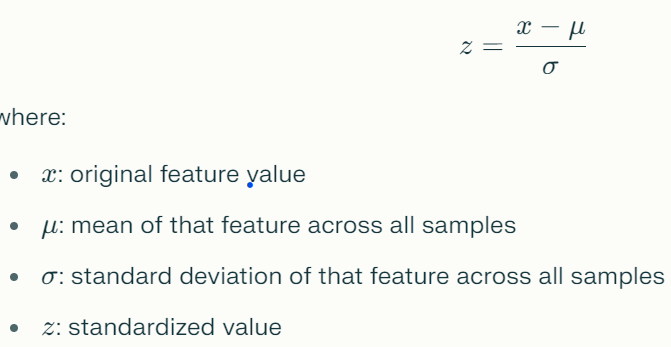

Note : Fits a standard scaler to your inputs and applies it:
        Each feature is centered and divided by its standard deviation.
        This ensures both input dimensions are on comparable scales.
        Helps the GP kernel optimization behave better (kernels are sensitive to scale).
<br>
Output Preprocessed using PowerTransformer : 
Proprocessing is required to data is to skewed with tiny positive numbers and some negative values. The Yeo-Johnson transofrmation is used to normalize such distributions as it works for both positive and negative values, and make the range and shape more manageable for Gaussian Process Modelling. Standardize= True is set so that after transformation this option subtracts the mean and divides by standard deviation so output data has zero mean and unit vairance.  <br>
Notes: PowerTransformer applies a non-linear transformation to each feature in the data to make its distribution more like a normal (Gaussian) distribution. This is helpful because many machine learning algorithms (including Gaussian Processes) work best when input data is more “bell-shaped” and less skewed. <br>
a)Power transforms the target y to make it more Gaussian-like. <br>
b)Handles very skewed or small/negative values better than log transforms. <br>
c)The GP assumes roughly Gaussian residuals → this helps that assumption. 

In [18]:
### Modify here to select function data
X=np.array(X2,dtype=float)
y=np.array(y2,dtype=float)
print(X)
print(y)
FunctionName = "f2"
SubmissionWk = "Wk5"


[[0.66579958 0.12396913]
 [0.87779099 0.7786275 ]
 [0.14269907 0.34900513]
 [0.84527543 0.71112027]
 [0.45464714 0.29045518]
 [0.57771284 0.77197318]
 [0.43816606 0.68501826]
 [0.34174959 0.02869772]
 [0.33864816 0.21386725]
 [0.70263656 0.9265642 ]
 [0.697615   0.558512  ]
 [0.712515   0.494346  ]
 [0.72394    0.607823  ]
 [0.597315   0.375839  ]]
[ 0.53899612  0.42058624 -0.06562362  0.29399291  0.21496451  0.02310555
  0.24461934  0.03874902 -0.01385762  0.61120522  0.65854113  0.77789304
  0.61047116 -0.00356468]


1) big picture
I have observed data (X,y) from a black‑box function and want the next query 
xnext that is most promising. I use a Gaussian Process (GP) surrogate to (a) fit the function and (b) compute an acquisition function—here Expected Improvement (EI)—over a grid of candidate points in 
[0,1] I then pick the candidate with the highest EI.

2) Preprocessing (why scale X and transform y)
StandardScaler(X): Centers and scales inputs so the GP kernel can learn balanced length‑scales across dimensions. This stabilizes optimization of kernel hyperparameters.

PowerTransformer(Yeo–Johnson) on y: Makes targets more Gaussian (reduces skew/heavy tails) and standardizes them. This aligns with the GP’s Gaussian noise assumption and improves stability.

We wrap the GP with TransformedTargetRegressor so the model learns on transformed y internally and delivers predictions in the same transformed space, which we then invert when we want original‑scale values.

4) Model selection and in‑sample check
I train several GP candidates, select the best by log marginal likelihood, then report training RMSE/R² in original y space (so the numbers are interpretable).

5) Expected Improvement (EI): what it computes and why in transformed space
EI idea: Balance exploitation (high mean μ) and exploration (high uncertainty σ). EI measures the expected gain above the current best.

Why transformed space? The GP is trained assuming Gaussian residuals on the transformed target. So 
μ, σ, and  ybest must be in the same transformed space for EI to be mathematically correct.

ξ (xi): A positive offset that pushes exploration. Larger ξ → more weight on high‑σ regions.

6) Candidate grid and choosing the next point
   
You evaluate EI everywhere on a 2D grid (original space).

Do not inverse_transform x_next: candidates are already in original space.

Only scale on the fly when calling predict(...).


7) Predicting y in original scale at the next point (the part you asked about)
The GP returns (μ,σ) in the transformed y‑space.
The mean in original space is simply inverse_transform(μ).
The uncertainty in original space is not just “inverse of σ” because the inverse transform is nonlinear. A simple, robust approximation is to inverse-transform the transformed bounds μ±σ and take half their distance as an “approx σ” in original space.
If you want a more accurate interval, sample 
yt∼N(μ,σ2), inverse‑transform each sample, and take the empirical std/quantiles (Monte Carlo).

9) Design choices (why we did it this way)

Candidates in original [0,1]: Minimizes mistakes. We only scale inputs inside predict and EI to be consistent with the trained GP.

EI in transformed space: Correctly matches the GP’s noise model and the transformed y.

Learnable noise: Keeping WhiteKernel learnable within bounds avoids brittle fits that fixed tiny noise can cause.

Multiple seeds: Increases the chance we find a good kernel hyperparameter configuration (the log marginal likelihood surface can have multiple local optima).

Original‑scale outputs for reporting: Human‑interpretable. The inverse transform ensures all “reported” y’s match your domain’s units/scale.

In [19]:

# ----------------------------
# Preprocessing
# ----------------------------
X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)
y_transformer = PowerTransformer(method="yeo-johnson", standardize=True)

# ----------------------------
# GP model + kernel (noise learnable)
# ----------------------------
kernel = (
    ConstantKernel(1.0, (1e-6, 1e3)) *
    Matern(length_scale=np.ones(X.shape[1]), length_scale_bounds=(1e-5, 1e5), nu=2.5)
    + WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-8, 1e-1))
)

best_model, best_score, best_seed = None, -np.inf, None
rng = np.random.default_rng(42)
seeds = rng.integers(0, 1000, size=10)

for seed in seeds:
    gpr = GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=False,          # target normalization handled by TTR
        n_restarts_optimizer=10,
        random_state=seed
    )
    model = TransformedTargetRegressor(regressor=gpr, transformer=y_transformer)
    model.fit(X_scaled, y)

    score = model.regressor_.log_marginal_likelihood(model.regressor_.kernel_.theta)
    print(f"Seed={seed}, LogMargLik={score:.8f}")
    if score > best_score:
        best_score, best_model, best_seed = score, model, seed

print("\n Best model selected:")
print(f"   Seed: {best_seed}")
print(f"   Log Marginal Likelihood: {best_score:.8f}")
print(f"   Kernel: {best_model.regressor_.kernel_}")

# ----------------------------
# In-sample fit quality (original space)
# ----------------------------
mu_tr, std_tr = best_model.regressor_.predict(X_scaled, return_std=True)  # transformed space
y_pred_orig = best_model.transformer_.inverse_transform(mu_tr.reshape(-1,1)).ravel()

rmse = np.sqrt(mean_squared_error(y, y_pred_orig))
r2 = r2_score(y, y_pred_orig)
print("\nModel Quality Summary:")
print(f"RMSE = {rmse:.6e}")
print(f"R²   = {r2:.6f}")


# ------------------------------------------------------------
# Current best observed (ORIGINAL space)
# ------------------------------------------------------------
best_obs_idx = int(np.argmax(y))                 # argmax on original y
x_best_obs = X[best_obs_idx]                     # ORIGINAL [0,1] coordinates
y_best_obs = float(y[best_obs_idx])              # ORIGINAL y value

# If you also want the transformed-space best (used by EI threshold),
# this is optional (EI already recomputes internally, but we can store it):
y_best_scaled = float(np.max(best_model.transformer_.transform(y.reshape(-1, 1))))

print(f"Best observed y (original) = {y_best_obs:.3e} at x = {np.round(x_best_obs,6).tolist()}")

# ----------------------------
# Expected Improvement
# ----------------------------
def expected_improvement(X_candidate, best_model, X_scaler, y, xi=0.01):
    """
    EI computed in transformed target space.
    Candidates X_candidate are in ORIGINAL [0,1] space.
    """
    Xc_scaled = X_scaler.transform(X_candidate)
    mu, sigma = best_model.regressor_.predict(Xc_scaled, return_std=True)  # transformed space
    mu = mu.ravel()
    sigma = np.maximum(sigma.ravel(), 1e-12)

    y_best_scaled = np.max(best_model.transformer_.transform(y.reshape(-1, 1)))
    Z = (mu - y_best_scaled - xi) / sigma
    ei = (mu - y_best_scaled - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma == 0.0] = 0.0
    return ei



# ----------------------------
# Candidate grid (2D)
# ----------------------------
xi_values = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_candidates = np.c_[X1.ravel(), X2.ravel()]  # ORIGINAL [0,1] space

os.makedirs("ei_plots", exist_ok=True)
summary_rows = []


for xi in xi_values:
    # ---- EI over candidate grid (transformed y-space) ----
    ei_vals = expected_improvement(X_candidates, best_model, X_scaler, y, xi)
    ei_grid = ei_vals.reshape(X1.shape)

    # ---- Next point (ORIGINAL [0,1] space) ----
    best_idx = np.argmax(ei_vals)
    x_next = X_candidates[best_idx]                 # original space
    x_next_scaled = X_scaler.transform([x_next])    # scaled only for prediction
    x_next_6dp = np.round(x_next, 6).tolist()

    # ---- Predict at next point (transformed -> back to original) ----
    mu_next, sigma_next = best_model.regressor_.predict(x_next_scaled, return_std=True)
    mu_next = float(mu_next.ravel()[0])                         # transformed mean
    sigma_next = float(max(sigma_next.ravel()[0], 1e-12))       # transformed std

    # Mean in ORIGINAL space
    y_next_mean_orig = float(best_model.transformer_.inverse_transform([[mu_next]])[0, 0])
    # Approx 1σ in ORIGINAL space via inverse-transform of (mu±σ)
    y_lo = best_model.transformer_.inverse_transform([[mu_next - sigma_next]])[0, 0]
    y_hi = best_model.transformer_.inverse_transform([[mu_next + sigma_next]])[0, 0]
    y_next_sigma_orig_approx = float(0.5 * (y_hi - y_lo))

    # ---- Console print so it's visible immediately ----
    print(
        f"ξ={xi:0.3f} → x_next (original) = {x_next_6dp}, "
        f"ŷ≈{y_next_mean_orig:.3e} ± {y_next_sigma_orig_approx:.3e} (original); "
        f"Best observed y={y_best_obs:.3e} at x={np.round(x_best_obs,6).tolist()}"
    )

    # ---- Plot EI (2D) and highlight both points ----
    plt.figure(figsize=(6, 5))
    plt.contourf(X1, X2, ei_grid, levels=20, cmap="viridis")

    # Observed points
    plt.scatter(X[:, 0], X[:, 1], c="white", edgecolors="black", s=35, label="Observed")

    # Best observed point (triangle)
    plt.scatter(x_best_obs[0], x_best_obs[1], c="deepskyblue", s=110, marker="^",
                edgecolors="black", label="Best observed")
    plt.annotate(
        f"best y={y_best_obs:.2e}",
        xy=(x_best_obs[0], x_best_obs[1]),
        xytext=(8, 8), textcoords="offset points",
        fontsize=8, bbox=dict(boxstyle="round,pad=0.15", fc="white", alpha=0.85)
    )

    # Next query point (star)
    plt.scatter(x_next[0], x_next[1], c="yellow", s=110, marker="*", edgecolors="black",
                label="Next query")
    plt.annotate(
        f"ŷ≈{y_next_mean_orig:.2e}\n±{y_next_sigma_orig_approx:.2e}",
        xy=(x_next[0], x_next[1]),
        xytext=(10, -12), textcoords="offset points",
        fontsize=8, bbox=dict(boxstyle="round,pad=0.15", fc="white", alpha=0.85)
    )

    plt.title(f"EI (BestSeed={best_seed}, ξ={xi})")
    plt.xlabel("x1"); plt.ylabel("x2")
    # Avoid duplicate legend entries when looping:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="best")
    plt.tight_layout()
    plt.savefig(f"ei_plots/EI_seed{best_seed}_xi{xi}_{SubmissionWk}_{FunctionName}.png", dpi=200)
    plt.close()

    # ---- Row for summary CSV (store both original & scaled) ----
    summary_rows.append({
        "BestSeed": best_seed,
        "Xi": xi,
        "LogMarginalLikelihood": best_score,

        # Next query (original/scaled)
        "NextQuery_X_original": x_next.tolist(),
        "NextQuery_X_original_6dp": x_next_6dp,
        "NextQuery_X_scaled": X_scaler.transform([x_next]).ravel().tolist(),

        # Pred at next query (original + transformed)
        "PredMean_original": y_next_mean_orig,
        "PredSigma_original_approx": y_next_sigma_orig_approx,
        "PredMean_transformed": mu_next,
        "PredSigma_transformed": sigma_next,

        # Best observed (original + transformed best)
        "BestObserved_y_original": y_best_obs,
        "BestObserved_X_original": x_best_obs.tolist(),
        "BestObserved_y_transformed_best": y_best_scaled,

        "Kernel": str(best_model.regressor_.kernel_),
    })


# Save summary
df_summary = pd.DataFrame(summary_rows).sort_values(by="LogMarginalLikelihood", ascending=False)
out_csv = f"ei_plots/EI_Model_Summary_{SubmissionWk}_{FunctionName}.csv"
df_summary.to_csv(out_csv, index=False)

print("\n✅ Summary saved:", out_csv)
print("EI plots saved in: ei_plots/")

# Report best observed y (both spaces)
y_scaled_all = best_model.transformer_.transform(y.reshape(-1, 1))
y_best_scaled = float(np.max(y_scaled_all))
y_best_original = float(best_model.transformer_.inverse_transform([[y_best_scaled]])[0, 0])

print("\nBest observed y (transformed):", y_best_scaled)
print("Best observed y (original):    ", y_best_original)

# Also show the top row from summary for convenience
print("\nTop row from summary:")
print(df_summary.iloc[0])


Seed=89, LogMargLik=-10.97793865
Seed=773, LogMargLik=-10.97793864
Seed=654, LogMargLik=-10.97793864
Seed=438, LogMargLik=-10.97793865
Seed=433, LogMargLik=-10.97793864
Seed=858, LogMargLik=-10.97793864
Seed=85, LogMargLik=-10.97793865
Seed=697, LogMargLik=-10.97793865
Seed=201, LogMargLik=-10.97793864
Seed=94, LogMargLik=-10.97793865

 Best model selected:
   Seed: 773
   Log Marginal Likelihood: -10.97793864
   Kernel: 0.96**2 * Matern(length_scale=[0.375, 12.4], nu=2.5) + WhiteKernel(noise_level=0.029)

Model Quality Summary:
RMSE = 3.044383e-02
R²   = 0.988202
Best observed y (original) = 7.779e-01 at x = [0.712515, 0.494346]
ξ=0.001 → x_next (original) = [0.707071, 0.0], ŷ≈7.266e-01 ± 9.835e-02 (original); Best observed y=7.779e-01 at x=[0.712515, 0.494346]
ξ=0.010 → x_next (original) = [0.707071, 0.0], ŷ≈7.266e-01 ± 9.835e-02 (original); Best observed y=7.779e-01 at x=[0.712515, 0.494346]
ξ=0.050 → x_next (original) = [0.707071, 0.0], ŷ≈7.266e-01 ± 9.835e-02 (original); Best obse

a) ConstantKernel: scales the entire covariance by a learned amplitude (how “tall” the function can be). <br>
b) Matern: defines how similarity decays with distance (smoothness, controlled by nu=2.5). <br>
c) length_scale=np.ones(X.shape[1]) → one scale per feature (Automatic Relevance Determination).<br>
d) WhiteKernel: adds small noise to the diagonal → prevents numerical instability.
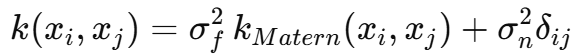

1. ConstantKernel(1.0, (1e-6, 1e3)) <br>
Purpose: This kernel multiplies the covariance function by a positive constant value, effectively scaling the overall variance (amplitude) of the GP.<br>
Initial value: 1.0 is the starting amplitude.<br>
Bounds: The amplitude can vary between very small (1e-6) and very large (1e3), allowing the optimizer to adjust it during fitting.<br>
Interpretation: Controls the vertical scale of the function values the GP expects.<br>

2. Matern kernel <br>
Purpose: Models smoothness and correlations of the function in input space. <br>
Parameters:<br>
> length_scale=np.ones(X.shape[1]) sets the initial length scale for each input dimension to 1. <br>
> length_scale_bounds=(1e-5, 1e5) allows the optimizer to tune these length scales widely.<br>
> nu=2.5 controls the smoothness; larger values mean smoother functions. nu=2.5 implies a twice differentiable function, balancing smoothness and flexibility.<br>
Interpretation: Determines how quickly correlation between points decays with distance. The Matern kernel is more general than the squared exponential kernel and can model rougher functions.<br>

3. WhiteKernel(noise_level=1e-10, noise_level_bounds="fixed") <br>
Purpose: Models observation noise (white noise) present in the measurements.<br>
noise_level=1e-10: Sets a very small fixed noise level, which is not optimized because noise_level_bounds="fixed". <br>
Interpretation: Adds diagonal terms to the covariance matrix to represent measurement or intrinsic noise in the data. <br>
Overall kernel composition <br>
The kernel is composed as:  <br>
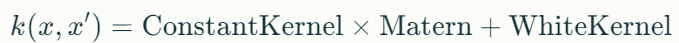
Multiplication (*): The ConstantKernel scales the Matern kernel, affecting the amplitude of variations. <br>
Addition (+): The WhiteKernel adds independent noise variance. <br>
Why this combination? <br>
The Matern kernel captures smooth but not overly restrictive functional forms, flexible enough to model many real-world processes.<br>
The ConstantKernel allows the model to adjust the overall amplitude of variation, crucial for adapting to different output scales.<br>
The WhiteKernel accounts for noise, preventing the GP from overfitting the training data.<br>

GaussianProcessRegressor<br>
1) Builds a Gaussian Process model using that kernel.<br>
2) normalize_y=False: we already transform y using PowerTransformer, so no need for internal normalization.<br>
3) n_restarts_optimizer=10: tries several random restarts to avoid local minima in kernel hyperparameter optimization.<br>
4) random_state=0: ensures reproducibility.<br>

1) Wraps the GP with TransformedTargetRegressor so it automatically applies the PowerTransformer to y. <br>
2) .fit(...) trains the GP:<br>
  a) Learns kernel parameters (length scales, signal variance, noise).<br>
  b) Stores the training data (used for prediction later).<br>

Defines a function to compute EI for candidate points :  <br> 
Defines Expected Improvement, a popular Bayesian Optimization acquisition function to balance exploration and exploitation. <br> 
xi: small positive constant controlling exploration–exploitation tradeoff. <br> 


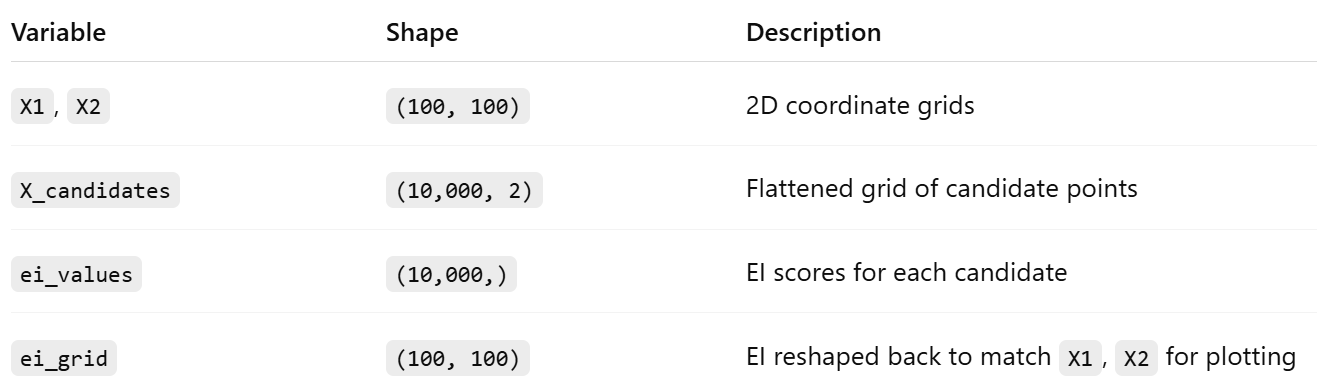
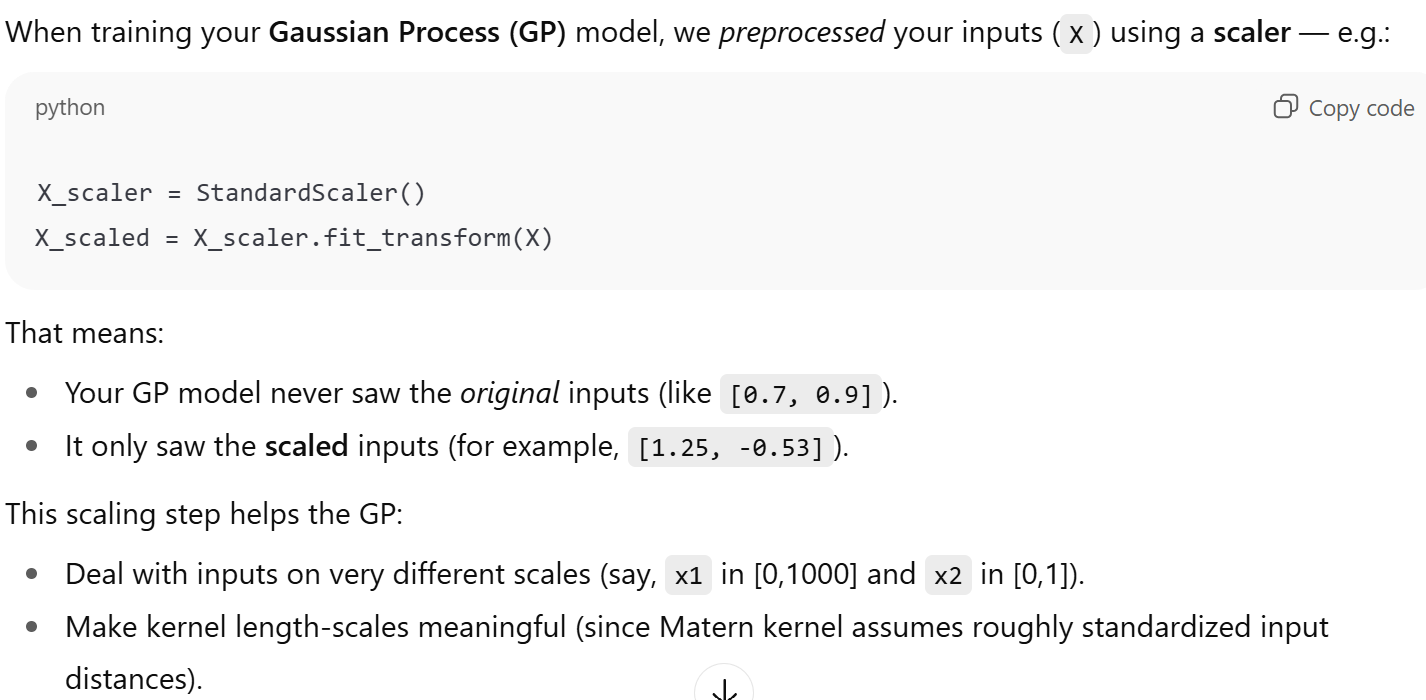


                              ******###### Try same with SVM ##############****
SVR as the surrogate model

1) Hyperparameter tuning of SVR with grid search or Bayesian optimization
2) Surrogate prediction
3) Model selection based on validation metrics


[[0.66579958 0.12396913]
 [0.87779099 0.7786275 ]
 [0.14269907 0.34900513]
 [0.84527543 0.71112027]
 [0.45464714 0.29045518]
 [0.57771284 0.77197318]
 [0.43816606 0.68501826]
 [0.34174959 0.02869772]
 [0.33864816 0.21386725]
 [0.70263656 0.9265642 ]
 [0.697615   0.558512  ]
 [0.712515   0.494346  ]
 [0.72394    0.607823  ]
 [0.597315   0.375839  ]]
[ 0.53899612  0.42058624 -0.06562362  0.29399291  0.21496451  0.02310555
  0.24461934  0.03874902 -0.01385762  0.61120522  0.65854113  0.77789304
  0.61047116 -0.00356468]
Best SVR params: {'regressor__svr__C': 1.0, 'regressor__svr__epsilon': 0.01}
SVR RMSE=1.896972e-01, R²=0.541934
n_support=14; support indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Best observed y (original) = 7.779e-01 at x=[0.712515, 0.494346]

--- NEXT QUERY SUGGESTION ---
Strategy: SVR hybrid: 0.5*mean + 0.3*grad + 0.2*dist
x_next (original): [0.845638, 0.295302]
ŷ_next (original): 5.763e-01
‖∇f‖ at x_next   : 3.675e+00

Saved plot to: svm_results\SVM_Wk5_f2_hy

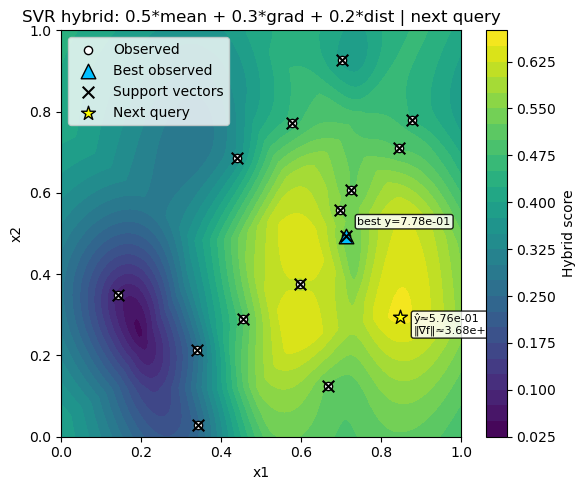

Saved CSV to: svm_results\SVM_Summary_Wk5_f2_hybrid.csv


In [20]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import qmc

# ----------------------------
# Your data (Function 1 example)
# ----------------------------
X = X    #Make sure X and y are NumPy arrays

y = y

print(X)
print(y)

FunctionName = FunctionName
SubmissionWk = SubmissionWk
out_dir = "svm_results"
os.makedirs(out_dir, exist_ok=True)


# -----------------------------------------
# 1) LEAKAGE-FREE MODEL: Pipeline + TTR + LOOCV
# -----------------------------------------
# - Standardize X inside the pipeline (so CV folds don't leak info)
# - Transform y with Yeo-Johnson, but return predictions in original y
pipe = make_pipeline(
    StandardScaler(),
    SVR(kernel="rbf", gamma="scale")
)
ttr = TransformedTargetRegressor(
    regressor=pipe,
    transformer=PowerTransformer(method="yeo-johnson", standardize=True)
)

param_grid = {
    "regressor__svr__C":       [0.1, 1.0, 10.0, 100.0],
    "regressor__svr__epsilon": [0.01, 0.05, 0.1, 0.2],
}
gcv = GridSearchCV(
    estimator=ttr,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=LeaveOneOut(),
    n_jobs=-1,
    refit=True,
)

gcv.fit(X, y)
model = gcv.best_estimator_                     # <— the refit TTR (on all data)
best_params = gcv.best_params_
print("Best SVR params:", best_params)

# Pull out trained pieces for inspection
pipe_best = model.regressor_                    # Pipeline(standardscaler, svr)
scaler    = pipe_best.named_steps["standardscaler"]
svr       = pipe_best.named_steps["svr"]

# -----------------------------------------
# 2) TRAINING METRICS (original y)
# -----------------------------------------
y_hat = model.predict(X)                        # TTR returns original-scale y
rmse = float(np.sqrt(mean_squared_error(y, y_hat)))
r2   = float(r2_score(y, y_hat))
print(f"SVR RMSE={rmse:.6e}, R²={r2:.6f}")

# -----------------------------------------
# 3) SUPPORT VECTORS (SVs)
# -----------------------------------------
sv_idx       = svr.support_
SV_scaled    = svr.support_vectors_             # scaled space (post StandardScaler)
SV_original  = scaler.inverse_transform(SV_scaled)
dual_coef    = svr.dual_coef_.ravel()
print(f"n_support={len(sv_idx)}; support indices={sv_idx.tolist()}")

# Best observed (original)
best_obs_idx = int(np.argmax(y))
x_best_obs   = X[best_obs_idx]
y_best_obs   = float(y[best_obs_idx])
print(f"Best observed y (original) = {y_best_obs:.3e} at x={np.round(x_best_obs,6).tolist()}")


# -----------------------------------------
# 4) RBF GRADIENT NORM (for exploration)
# -----------------------------------------
def _effective_gamma(svr_obj: SVR) -> float:
    """Numeric gamma actually used by SVR. sklearn stores it on svr._gamma."""
    if hasattr(svr_obj, "_gamma"):
        return float(svr_obj._gamma)
    # Fallback (rare): if gamma='scale' with standardized X, var≈1 so ~1/d
    return 1.0 / svr_obj.n_features_in_

def rbf_grad_norm_original_from_model(model_ttr: TransformedTargetRegressor,
                                      X_query_orig: np.ndarray) -> np.ndarray:
    """
    Compute ||∇_x f(x)|| in ORIGINAL units for SVR with RBF kernel, using the fitted model.
    """
    pipe = model_ttr.regressor_
    scaler = pipe.named_steps["standardscaler"]
    svr = pipe.named_steps["svr"]

    Xq_scaled = scaler.transform(X_query_orig)       # (N,d)
    SV = svr.support_vectors_                        # (m,d) scaled
    alpha = svr.dual_coef_.ravel()                   # (m,)
    gamma = _effective_gamma(svr)

    grad_scaled = np.zeros_like(Xq_scaled)           # (N,d)
    for j in range(SV.shape[0]):
        diff   = Xq_scaled - SV[j]                   # (N,d)
        sqnorm = np.sum(diff**2, axis=1)             # (N,)
        Kj     = np.exp(-gamma * sqnorm)             # (N,)
        grad_scaled += (alpha[j] * (-2.0 * gamma)) * (Kj[:, None] * diff)

    # Convert gradient from scaled-x units to ORIGINAL-x units: dx_orig = dx_scaled / scale
    grad_original = grad_scaled / scaler.scale_[None, :]
    return np.linalg.norm(grad_original, axis=1)     # (N,)


# -----------------------------------------
# 5) CANDIDATES (2D grid for plotting; ≥3D → Sobol)
# -----------------------------------------
dim = X.shape[1]
if dim == 2:
    n_grid = 150
    x1 = np.linspace(0, 1, n_grid)
    x2 = np.linspace(0, 1, n_grid)
    X1, X2 = np.meshgrid(x1, x2)
    X_candidates = np.c_[X1.ravel(), X2.ravel()]      # ORIGINAL [0,1]^2
else:
    sob = qmc.Sobol(d=dim, scramble=True, seed=123)
    X_candidates = sob.random(20000)                  # ORIGINAL [0,1]^d
    X1 = X2 = None


# -----------------------------------------
# 6) ACQUISITION: mean-only or hybrid(mean+grad+dist)
# -----------------------------------------
# Predicted mean (original y) at candidates
y_cand_mean = model.predict(X_candidates)             # (N,)

# Gradient norm (original-x units) at candidates
grad_norm = rbf_grad_norm_original_from_model(model, X_candidates)  # (N,)

# Distance to nearest training point (original space)
def min_dist_to_train(Xcand: np.ndarray, Xtrain: np.ndarray) -> np.ndarray:
    d2 = ((Xcand[:, None, :] - Xtrain[None, :, :])**2).sum(axis=2)  # (N,n)
    return np.sqrt(d2.min(axis=1))                                  # (N,)

dist2train = min_dist_to_train(X_candidates, X)

# Normalize each to [0,1] for mixing
def norm01(v):
    v = np.asarray(v, float)
    lo, hi = np.nanmin(v), np.nanmax(v)
    return np.zeros_like(v) if hi <= lo else (v - lo) / (hi - lo)

mean_n = norm01(y_cand_mean)     # maximize
grad_n = norm01(grad_norm)       # explore steep
dist_n = norm01(dist2train)      # explore novel

# Choose strategy
strategy = "hybrid"  # "mean" (exploit) or "hybrid" (explore+exploit)
if strategy == "mean":
    score = y_cand_mean
    acq_name = "SVR mean-only (exploit)"
else:
    # You can tune weights; early rounds: push grad/dist higher
    w_mean, w_grad, w_dist = 0.5, 0.3, 0.2
    score = w_mean*mean_n + w_grad*grad_n + w_dist*dist_n
    acq_name = f"SVR hybrid: {w_mean}*mean + {w_grad}*grad + {w_dist}*dist"

# Next query (argmax of acquisition)
best_idx = int(np.argmax(score))
x_next   = np.clip(X_candidates[best_idx], 0.0, 1.0)   # ORIGINAL [0,1]
y_next   = float(model.predict(x_next.reshape(1, -1))[0])
grad_next = float(rbf_grad_norm_original_from_model(model, x_next.reshape(1, -1))[0])

print("\n--- NEXT QUERY SUGGESTION ---")
print("Strategy:", acq_name)
print("x_next (original):", np.round(x_next, 6).tolist())
print("ŷ_next (original):", f"{y_next:.3e}")
print("‖∇f‖ at x_next   :", f"{grad_next:.3e}")


# -----------------------------------------
# 7) PLOT + SAVE + SHOW
# -----------------------------------------
if dim == 2:
    plt.figure(figsize=(6, 5))
    if strategy == "mean":
        Z = y_cand_mean.reshape(X1.shape)
        ttl = f"SVR surrogate mean | next query"
        cbl = "Predicted y"
    else:
        Z = score.reshape(X1.shape)
        ttl = f"{acq_name} | next query"
        cbl = "Hybrid score"
    cs = plt.contourf(X1, X2, Z, levels=24, cmap="viridis")
    plt.colorbar(cs, label=cbl)

    # Observed data
    plt.scatter(X[:,0], X[:,1], c="white", edgecolors="black", s=35, label="Observed")

    # Best observed
    plt.scatter(x_best_obs[0], x_best_obs[1], c="deepskyblue", s=110, marker="^",
                edgecolors="black", label="Best observed")
    plt.annotate(f"best y={y_best_obs:.2e}", xy=(x_best_obs[0], x_best_obs[1]),
                 xytext=(8, 8), textcoords="offset points",
                 fontsize=8, bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.85))

    # Support vectors (original)
    if len(sv_idx):
        plt.scatter(SV_original[:,0], SV_original[:,1], c="black", s=70, marker="x",
                    label="Support vectors")

    # Next query
    plt.scatter(x_next[0], x_next[1], c="yellow", s=110, marker="*", edgecolors="black",
                label="Next query")
    plt.annotate(f"ŷ≈{y_next:.2e}\n‖∇f‖≈{grad_next:.2e}", xy=(x_next[0], x_next[1]),
                 xytext=(10, -12), textcoords="offset points",
                 fontsize=8, bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.85))

    plt.title(ttl)
    plt.xlabel("x1"); plt.ylabel("x2")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="best")
    plt.tight_layout()

    png_path = os.path.join(out_dir, f"SVM_{SubmissionWk}_{FunctionName}_{strategy}.png")
    plt.savefig(png_path, dpi=200)
    print("\nSaved plot to:", png_path)
    plt.show()  # <— show the figure at end of run


# -----------------------------------------
# 8) CSV SUMMARY (everything to reproduce)
# -----------------------------------------
summary = pd.DataFrame([{
    "Function": FunctionName,
    "Week": SubmissionWk,
    "Strategy": strategy,
    "BestParams": json.dumps(best_params),
    "RMSE": rmse, "R2": r2,
    "BestObserved_y": y_best_obs,
    "BestObserved_x": json.dumps(x_best_obs.tolist()),
    "NextQuery_x_original": json.dumps(x_next.tolist()),
    "Predicted_y_next": y_next,
    "GradNorm_next": grad_next,
    "n_support": int(len(sv_idx)),
    "Support_idx": json.dumps(sv_idx.tolist()),
    "Support_x_original": json.dumps(SV_original.tolist()),
    "DualCoef_support": json.dumps(dual_coef.tolist()),
}])
csv_path = os.path.join(out_dir, f"SVM_Summary_{SubmissionWk}_{FunctionName}_{strategy}.csv")
summary.to_csv(csv_path, index=False)
print("Saved CSV to:", csv_path)

Macro Steps for SVM :
1)Preprocess inputs/outputs so the model is stable.
2)Fit an SVR (RBF kernel) with LOOCV grid search to pick C and ε.
3)Extract support vectors (SVs): points that actually shape the fitted surface.
4)Score a dense candidate set of x’s with either:
mean-only (pure exploitation), or
a hybrid score (mean + steepness + novelty) to encourage exploration.
5)Pick the argmax as your next query and plot/save everything.

Why scale X? RBF kernels use distances; scaling avoids one feature dominating.

Why transform y? Yeo–Johnson reduces skew & variance: the SVR is fit on transformed-y but you’ll get predictions back in original-y via the wrapper (next block).

the SVR “hybrid” score pulled you to the corner because of how it mixes mean + gradient + novelty:

the distance-to-train term rewards being far from data → edges/corners,

the gradient-norm term also tends to be large where the model is less certain → again near boundaries,

with tiny target magnitudes, the mean term can’t counterbalance those pulls.

Saved plot to: svm_results\SVR_f1_Wk5_grid.png


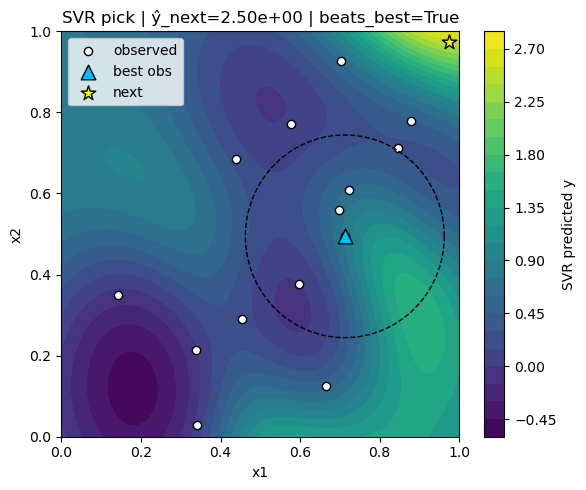


Best observed y = 7.779e-01 at x = [0.712515, 0.494346]
Chosen ŷ_next  = 2.496e+00 at x_next = [0.974874, 0.974874]
Selected SVR hp = C:100.0, eps:0.001, gamma:scale
Fit metrics     = RMSE:2.948e-04, R²:1.0000
{
  "x_next": [
    0.9748743718592965,
    0.9748743718592965
  ],
  "y_pred_next": 2.4964650149643512,
  "beats_best": true,
  "best_obs": {
    "x": [
      0.712515,
      0.494346
    ],
    "y": 0.777893037219951
  },
  "svr_params": {
    "C": 100.0,
    "epsilon": 0.001,
    "gamma": "scale"
  },
  "rmse": 0.0002947818923816636,
  "r2": 0.9999988938666762
}


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import json, os
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score

# -------------------------
# helpers
# -------------------------
def soft_edge_penalty(Xcand, margin=0.05):
    d_to_faces = [Xcand[:,0], 1-Xcand[:,0], Xcand[:,1], 1-Xcand[:,1]]
    edge_dist = np.minimum.reduce(d_to_faces)
    return np.clip((margin - edge_dist)/margin, 0.0, 1.0)

def trust_region_bias(Xcand, x_center, r_tr=0.25):
    d = np.linalg.norm(Xcand - x_center[None,:], axis=1)
    return 1.0 - np.clip(d / r_tr, 0.0, 1.0)

def fit_svr_ttr(X, y, C, eps, gamma="scale", use_identity=False):
    pipe = make_pipeline(StandardScaler(), SVR(kernel="rbf", C=C, epsilon=eps, gamma=gamma))
    transformer = FunctionTransformer(validate=False) if use_identity \
                  else PowerTransformer(method="yeo-johnson", standardize=True)
    return TransformedTargetRegressor(regressor=pipe, transformer=transformer).fit(X, y)

# -------------------------
# main routine
# -------------------------
def svr_next_point_2d_hyperloop(
    X, y,
    C_grid=(0.1, 1.0, 10.0, 100.0),
    eps_grid=(0.001, 0.01, 0.05, 0.1),
    gamma_grid=("scale",),
    n_grid=200,
    force_beats_best=True,
    tol_rel=0.02,          # require +2% above best (when |best| not tiny)
    tol_abs=1e-6,          # or +1e-6 when best ~ 0
    use_identity_transform=False,
    use_penalties=True,    # trust-region + edge penalty (soft)
    r_tr=0.25, w_tr=0.25, margin=0.05, w_edge=0.5,
    plot=True, out_dir=None, label="f1_Wk5"
):
    X = np.asarray(X, float); y = np.asarray(y, float).ravel()
    assert X.shape[1] == 2, "This helper is for 2D only."

    # incumbent and thresholds
    i_best = int(np.argmax(y)); x_best = X[i_best].copy(); y_best = float(y[i_best])
    thr = (y_best + max(abs(y_best)*tol_rel, tol_abs)) if force_beats_best else -np.inf

    # candidate mesh
    x1 = np.linspace(0, 1, n_grid); x2 = np.linspace(0, 1, n_grid)
    X1, X2 = np.meshgrid(x1, x2); Xcand = np.c_[X1.ravel(), X2.ravel()]

    best_pick = None  # (y_pred, x, (C,eps,gamma))
    best_over_thr = None

    # try all hyperparams (mean-only exploitation as the scoring)
    for C in C_grid:
        for eps in eps_grid:
            for gamma in gamma_grid:
                model = fit_svr_ttr(X, y, C=C, eps=eps, gamma=gamma, use_identity=use_identity_transform)

                # mean prediction at candidates (original y space)
                y_mean = model.predict(Xcand)

                # optional penalties (applied to selection, not to ŷ itself)
                if use_penalties:
                    tr_b = trust_region_bias(Xcand, x_best, r_tr=r_tr)
                    e_pen = soft_edge_penalty(Xcand, margin=margin)
                    score = y_mean + w_tr*tr_b - w_edge*e_pen
                else:
                    score = y_mean

                # candidate that (a) maximizes score, (b) we’ll also check if its ŷ beats current best
                j = int(np.argmax(score))
                x_next = Xcand[j]
                y_pred = float(y_mean[j])

                # track global best (any) and best that beats threshold
                if (best_pick is None) or (y_pred > best_pick[0]):
                    best_pick = (y_pred, x_next, (C, eps, gamma))
                if y_pred > thr and ((best_over_thr is None) or (y_pred > best_over_thr[0])):
                    best_over_thr = (y_pred, x_next, (C, eps, gamma))

    # choose final suggestion
    chosen = best_over_thr if (force_beats_best and best_over_thr is not None) else best_pick
    y_pred, x_next, hp = chosen
    C_sel, eps_sel, gamma_sel = hp

    # quick metrics on training fit of the chosen model (just for info)
    chosen_model = fit_svr_ttr(X, y, C=C_sel, eps=eps_sel, gamma=gamma_sel, use_identity=use_identity_transform)
    y_hat_tr = chosen_model.predict(X)
    rmse = float(np.sqrt(mean_squared_error(y, y_hat_tr)))
    r2   = float(r2_score(y, y_hat_tr))

    # plot
    if plot:
        Z = chosen_model.predict(Xcand).reshape(X1.shape)
        plt.figure(figsize=(6,5))
        cs = plt.contourf(X1, X2, Z, levels=24, cmap="viridis")
        plt.colorbar(cs, label="SVR predicted y")
        plt.scatter(X[:,0], X[:,1], c="white", edgecolors="black", s=35, label="observed")
        plt.scatter(x_best[0], x_best[1], c="deepskyblue", s=110, marker="^", edgecolors="black", label="best obs")
        plt.scatter(x_next[0], x_next[1], c="yellow", s=120, marker="*", edgecolors="black", label="next")
        if use_penalties:
            th = np.linspace(0,2*np.pi,200)
            plt.plot(x_best[0]+r_tr*np.cos(th), x_best[1]+r_tr*np.sin(th), "--", c="k", lw=1)
        ttl = f"SVR pick | ŷ_next={y_pred:.2e} | beats_best={y_pred>y_best}"
        plt.title(ttl); plt.xlabel("x1"); plt.ylabel("x2"); plt.xlim(0,1); plt.ylim(0,1)
        plt.legend(loc="best"); plt.tight_layout()
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)
            png_path = os.path.join(out_dir, f"SVR_{label}_grid.png")
            plt.savefig(png_path, dpi=200)
            print("Saved plot to:", png_path)
        plt.show()

    print(f"\nBest observed y = {y_best:.3e} at x = {np.round(x_best,6).tolist()}")
    print(f"Chosen ŷ_next  = {y_pred:.3e} at x_next = {np.round(x_next,6).tolist()}")
    print(f"Selected SVR hp = C:{C_sel}, eps:{eps_sel}, gamma:{gamma_sel}")
    print(f"Fit metrics     = RMSE:{rmse:.3e}, R²:{r2:.4f}")
    return {
        "x_next": x_next.tolist(),
        "y_pred_next": y_pred,
        "beats_best": bool(y_pred > y_best),
        "best_obs": {"x": x_best.tolist(), "y": y_best},
        "svr_params": {"C": C_sel, "epsilon": eps_sel, "gamma": gamma_sel},
        "rmse": rmse, "r2": r2
    }

# -------------------------



# Example: using your f1 numbers (make sure they are valid Python lists with commas)
X = np.array(X, dtype=float)
y = np.array(y, dtype=float)

# Run
res = svr_next_point_2d_hyperloop(X, y, force_beats_best=True, use_penalties=True,
                                  use_identity_transform=False, n_grid=200,
                                   out_dir="svm_results", label="f1_Wk5")
print(json.dumps(res, indent=2))


--------------------------Nural Network ------------------

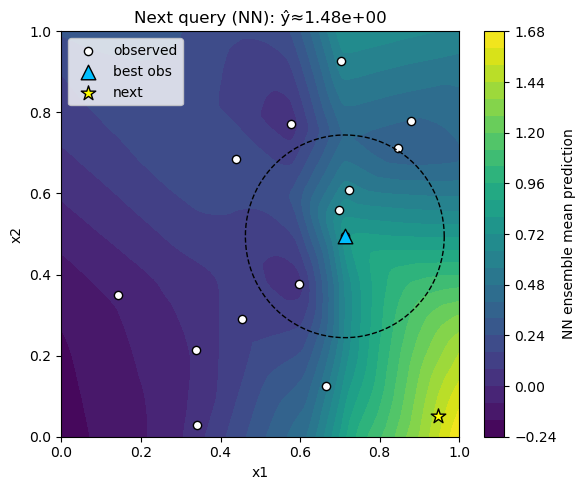

Best observed y: 7.779e-01 at x: [0.712515, 0.494346]
Proposed x_next: [0.947791, 0.052209]   Pred ŷ: 1.477e+00


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler,PowerTransformer

# ---------- your data ----------
X = np.array(X, dtype=float)

y = np.array(y, dtype=float).ravel()

# ---------- tiny helpers ----------
def soft_edge_penalty(Xcand, margin=0.05):
    d_to_faces = [Xcand[:,0], 1-Xcand[:,0], Xcand[:,1], 1-Xcand[:,1]]
    edge_dist = np.minimum.reduce(d_to_faces)
    return np.clip((margin - edge_dist)/margin, 0.0, 1.0)

def trust_region_bias(Xcand, x_center, r_tr=0.25):
    d = np.linalg.norm(Xcand - x_center[None,:], axis=1)
    return 1.0 - np.clip(d / r_tr, 0.0, 1.0)

# ---------- fit small NN ensemble ----------
sx = StandardScaler().fit(X)
Xs = sx.transform(X)
sy = PowerTransformer(method="yeo-johnson", standardize=True).fit(y.reshape(-1,1))
ys = sy.transform(y.reshape(-1,1)).ravel()
def fit_one(seed):
    return MLPRegressor(
        hidden_layer_sizes=(32,32), 
        activation="relu", 
        solver="adam",
        alpha=1e-4, 
        learning_rate_init=1e-3, 
        max_iter=600,
        random_state=seed
        ).fit(Xs, ys)

rng = np.random.default_rng(0)
ensemble = [fit_one(int(s)) for s in rng.integers(0, 10000, size=9)]  #Build an ensemble of 9 MLPs, each with a different random seed.

# ---------- candidates & scoring ----------
n_grid = 250
g = np.linspace(0, 1, n_grid)
X1, X2 = np.meshgrid(g, g)
Xcand = np.c_[X1.ravel(), X2.ravel()]   # Create a dense grid of candidate points over [0,1]^2 : 250×250 = 62,500 points.
Xcand_s = sx.transform(Xcand)

# ensemble mean prediction in original y scale
preds_tr = np.stack([m.predict(Xcand_s) for m in ensemble], axis=0)  # (B,N)   #Predict with each ensemble member on all candidates (in transformed y space).
mu_tr = preds_tr.mean(axis=0)    #Average predictions → ensemble mean in transformed space.
mu = sy.inverse_transform(mu_tr.reshape(-1,1)).ravel()   #Inverse-transform back to original y scale → mu (length N).

# incumbent  (Find the current best observed y and its x)
i_best = int(np.argmax(y)); x_best = X[i_best].copy(); y_best = float(y[i_best])

# simple, robust selection: mean + soft TR boost − soft edge penalty
w_tr, r_tr = 0.25, 0.25
w_edge, margin = 0.5, 0.05
score = mu + w_tr*trust_region_bias(Xcand, x_best, r_tr=r_tr) - w_edge*soft_edge_penalty(Xcand, margin=margin)

j = int(np.argmax(score))
x_next = Xcand[j]
y_pred_next = float(mu[j])

# ---------- show & print ----------
plt.figure(figsize=(6,5))
cs = plt.contourf(X1, X2, mu.reshape(X1.shape), levels=24, cmap="viridis")
plt.colorbar(cs, label="NN ensemble mean prediction")
plt.scatter(X[:,0], X[:,1], c="white", edgecolors="black", s=35, label="observed")
plt.scatter(x_best[0], x_best[1], c="deepskyblue", s=110, marker="^", edgecolors="black", label="best obs")
plt.scatter(x_next[0], x_next[1], c="yellow", s=120, marker="*", edgecolors="black", label="next")
th = np.linspace(0,2*np.pi,200)
plt.plot(x_best[0]+r_tr*np.cos(th), x_best[1]+r_tr*np.sin(th), "--", c="k", lw=1)
plt.xlabel("x1"); plt.ylabel("x2"); plt.xlim(0,1); plt.ylim(0,1)
plt.title(f"Next query (NN): ŷ≈{y_pred_next:.2e}")
plt.legend(loc="best"); plt.tight_layout(); plt.show()

print("Best observed y:", f"{y_best:.3e}", "at x:", np.round(x_best,6).tolist())
print("Proposed x_next:", np.round(x_next,6).tolist(), "  Pred ŷ:", f"{y_pred_next:.3e}")


soft_edge_penalty(Xcand, margin=0.05): 
→ computes a penalty value between 0 and 1 for each candidate point Xcand (points in [0,1]²),
where:

0 = safely inside the search space (not near the edge),

1 = right on or beyond the edge.

This penalty can then be subtracted from your acquisition function so the optimizer prefers interior points.

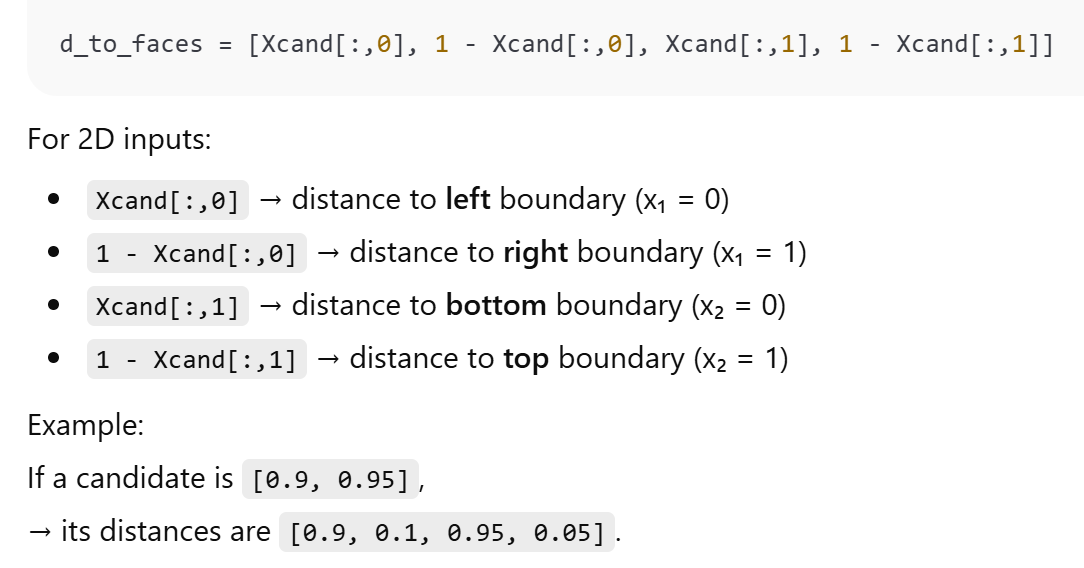
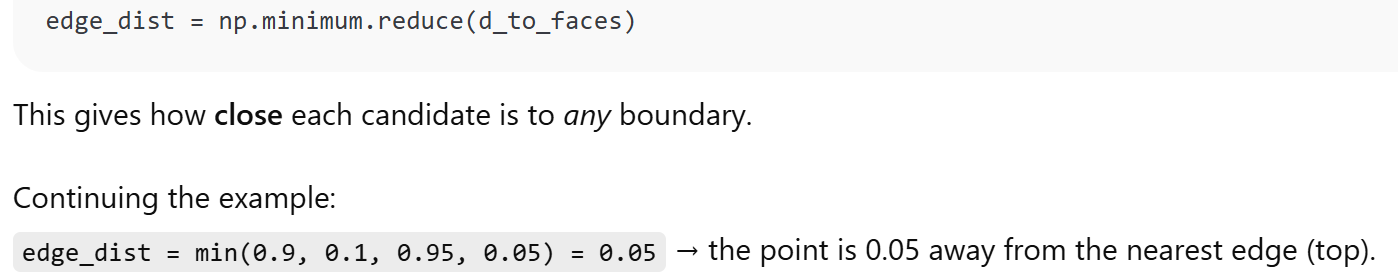
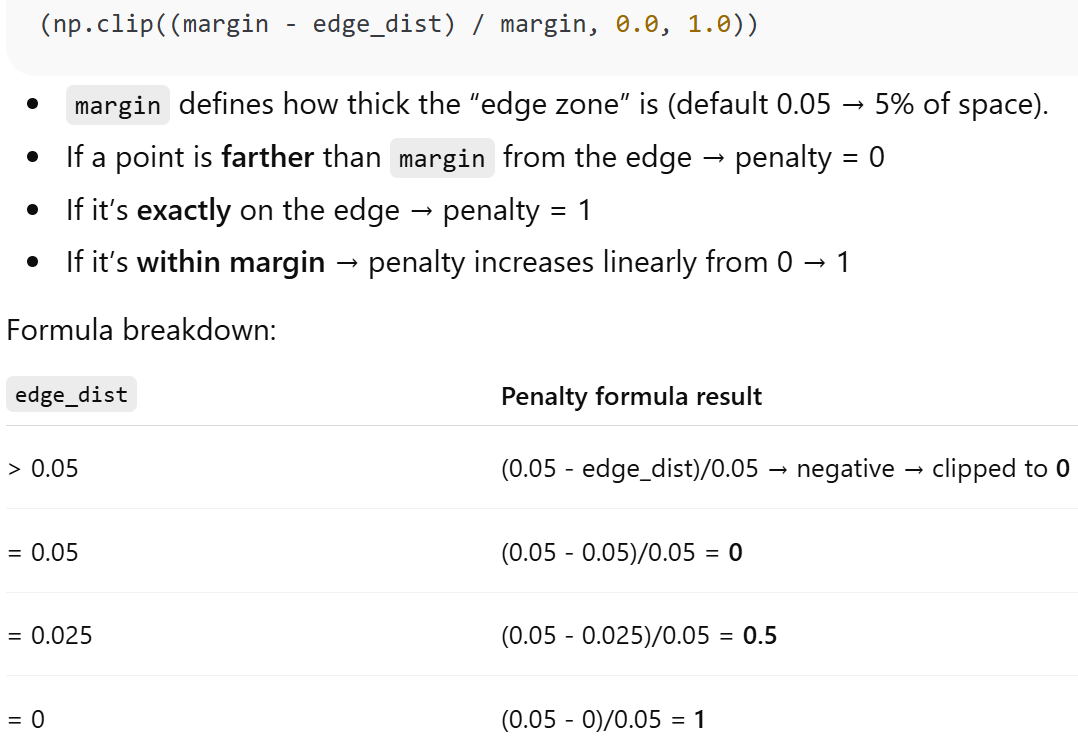
Returns a 1D array of length len(Xcand) with penalty values.
→ 0 → safe interior
→ 1 → edge or corner
→ ~0.5 → near the boundary zone

Note : 
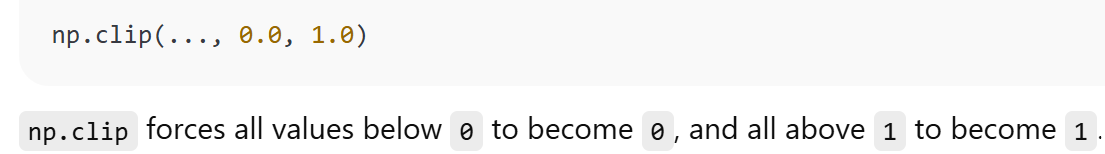
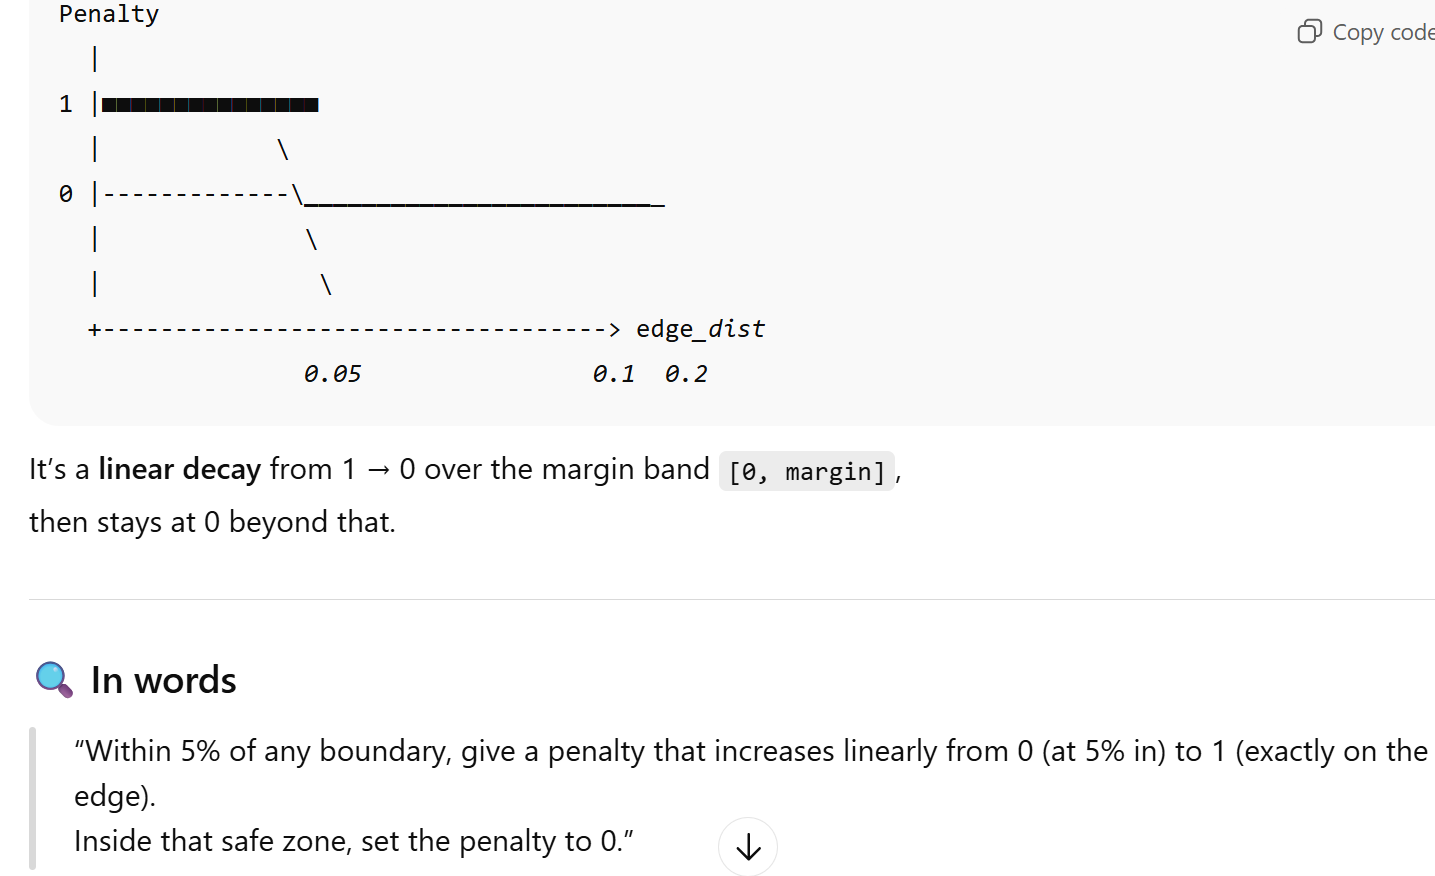
This way:

Points right on edges get heavily penalised (discouraged).

Points comfortably inside are unaffected.

Points slightly near edges get a moderate push toward the interior.

In Bayesian optimization, a trust region (TR) is a local area around your current best point (x_center or incumbent) where you “trust” the model most — and where you prefer to keep exploring as long as improvement continues.

So this function builds a soft weighting factor between 1 (at the center) and 0 (far outside the trust region).
You’ll later add it to your acquisition function to bias candidate selection toward the current best point’s neighborhood.

function :  def trust_region_bias(Xcand, x_center, r_tr=0.25):

Xcand: array of candidate points, shape (N, d) (e.g. 10000 × 2 for 2D grid).

x_center: your best point so far, shape (d,).

r_tr: the radius of the trust region (default 0.25, i.e. 25% of the [0,1] range).
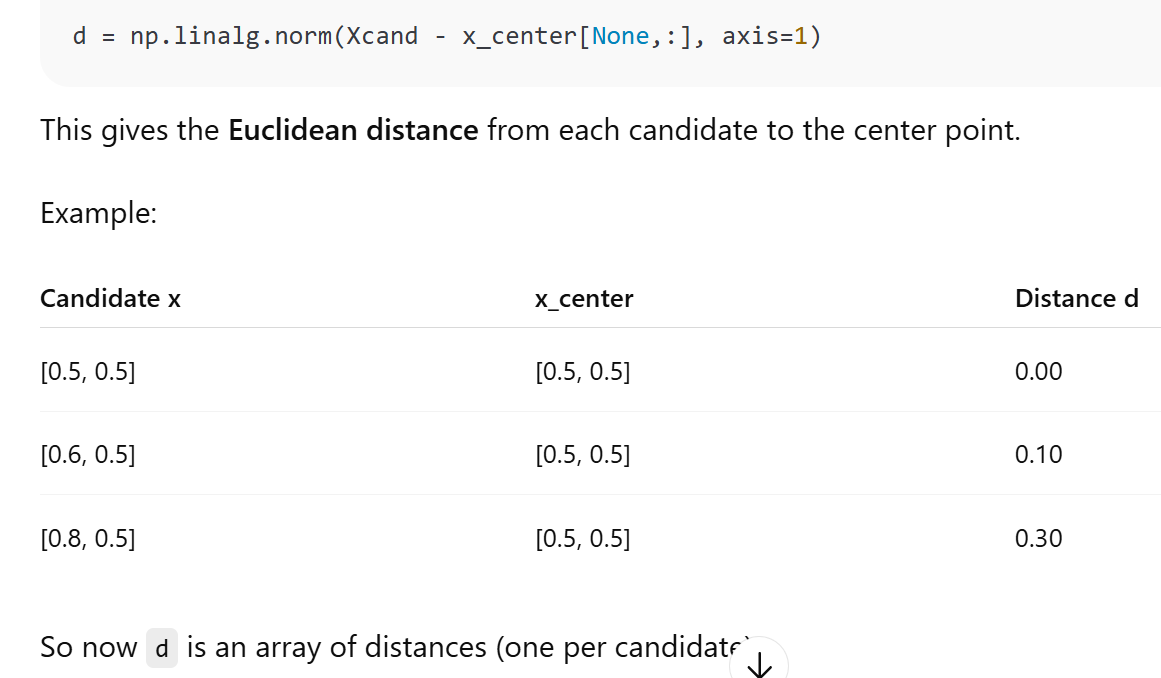
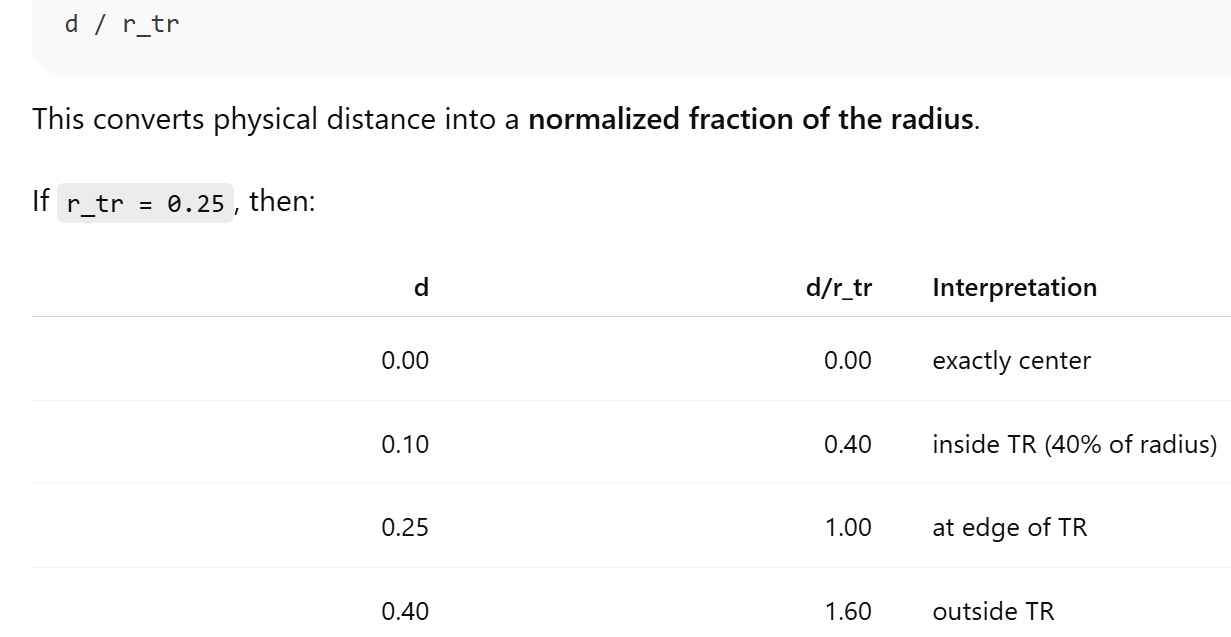
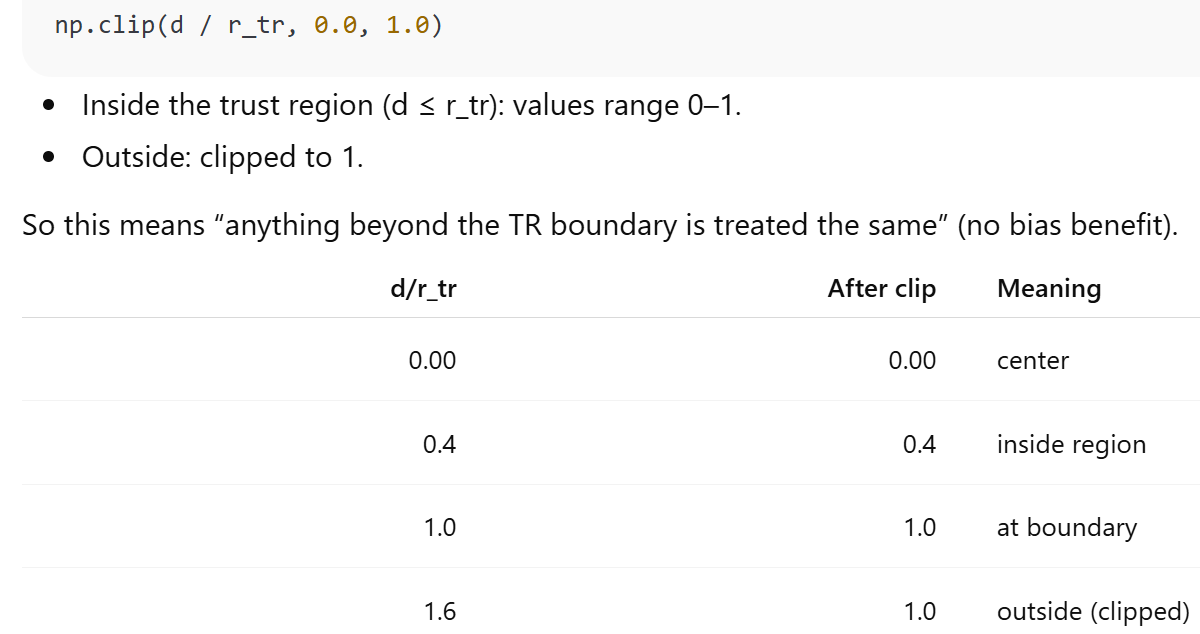
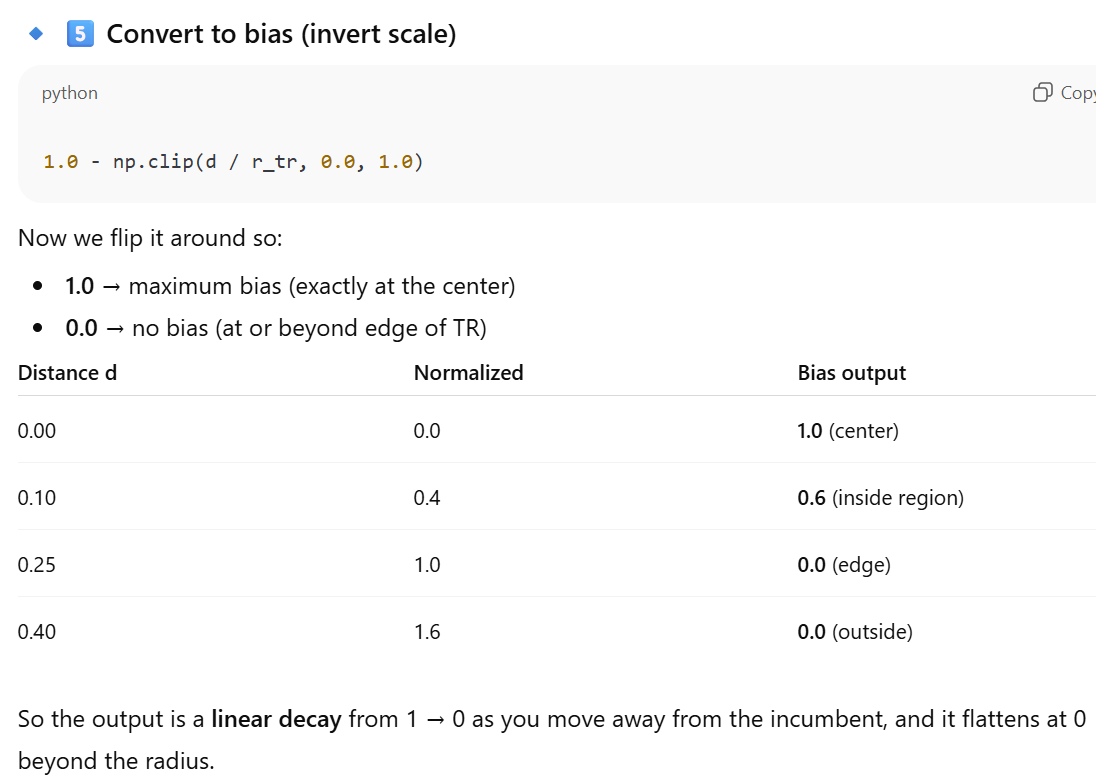
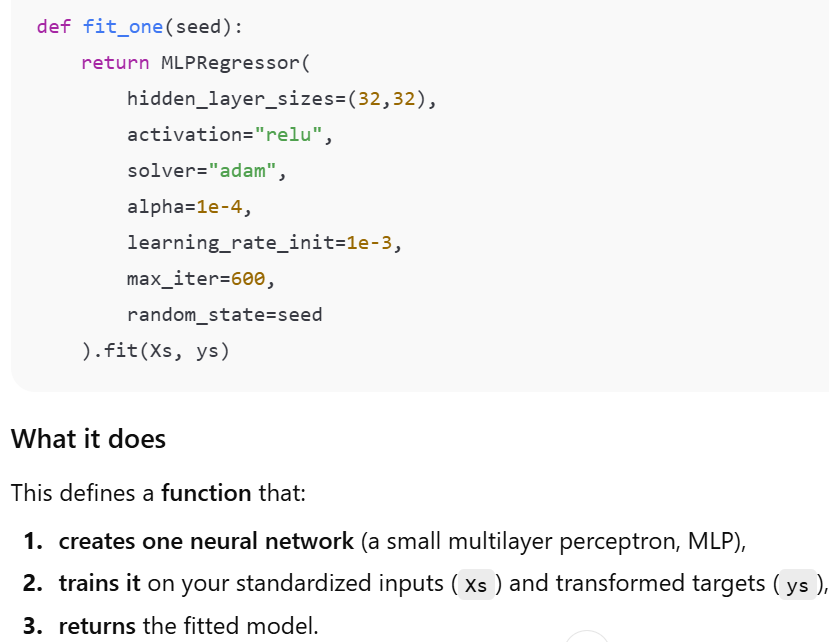
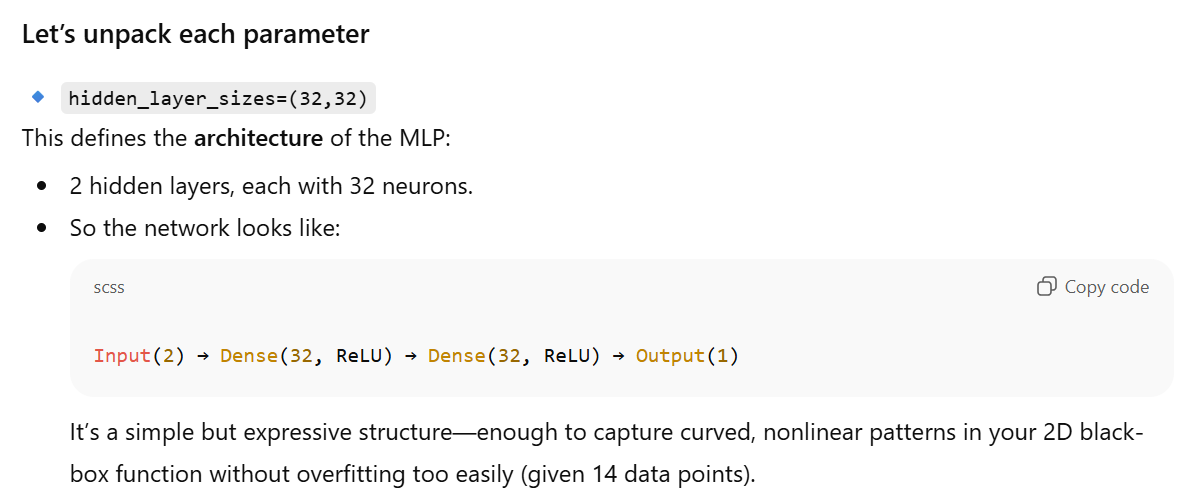

🔹 solver="adam"

“Adam” is the optimizer used for backpropagation.

It’s adaptive and works well on small datasets with minimal tuning.

Combines the best features of RMSProp and momentum SGD—good default choice.
🔹 alpha=1e-4

This is L2 regularization strength (also called weight decay).

It prevents the network weights from growing too large and overfitting.

1e-4 is a mild regularization — good for small data.

🔹 learning_rate_init=1e-3

The initial learning rate of Adam.

Controls how big each update step is during training.

1e-3 is a very typical starting point.

🔹 max_iter=600

The maximum number of training iterations (epochs).

Enough for small 2D data to converge without overtraining.
🔹 random_state=seed

Sets the random seed for weight initialization.

Ensures that each call to fit_one() can use different random weights if we pass in different seed values.

This is crucial for building an ensemble (next step).

🔹 .fit(Xs, ys)

Actually trains the model on:

Xs: standardized inputs (mean 0, std 1)

ys: Yeo–Johnson transformed targets (roughly Gaussian)

Returns the trained model.

Why define it as a function?

By wrapping it in a function that takes a seed, we can easily train multiple independent networks with different random initializations.
Each will learn slightly different patterns — and we can average them later to get a smoother, more robust prediction.

This is exactly what’s done in the next step.
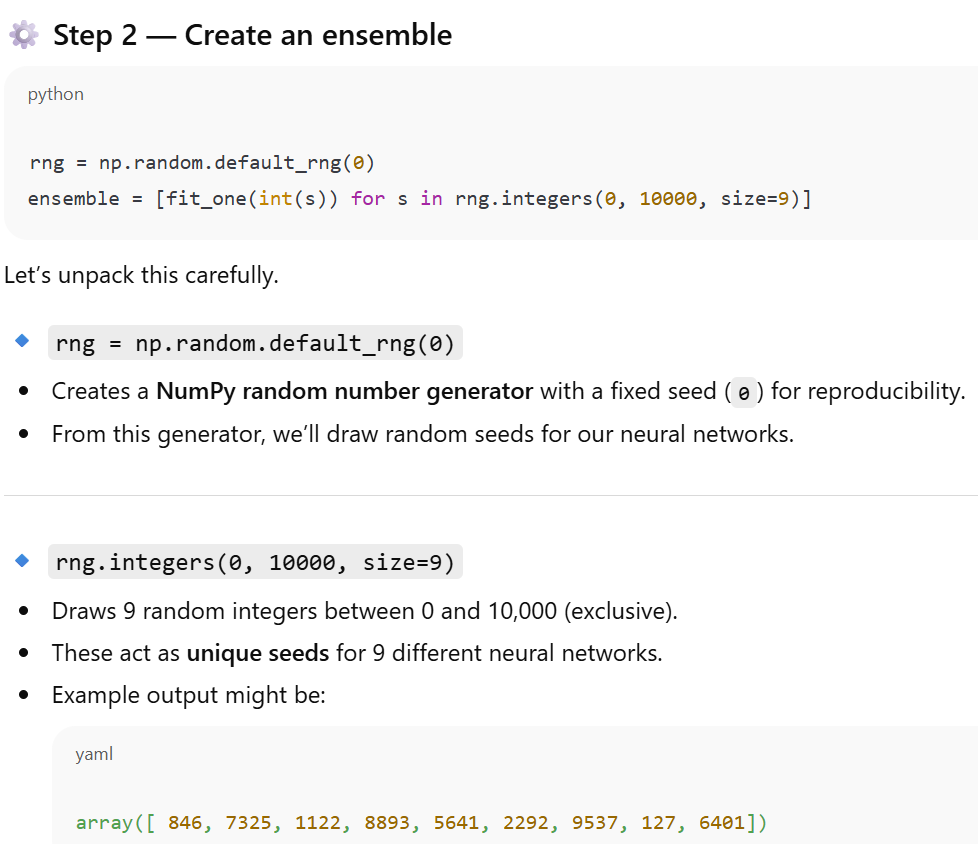
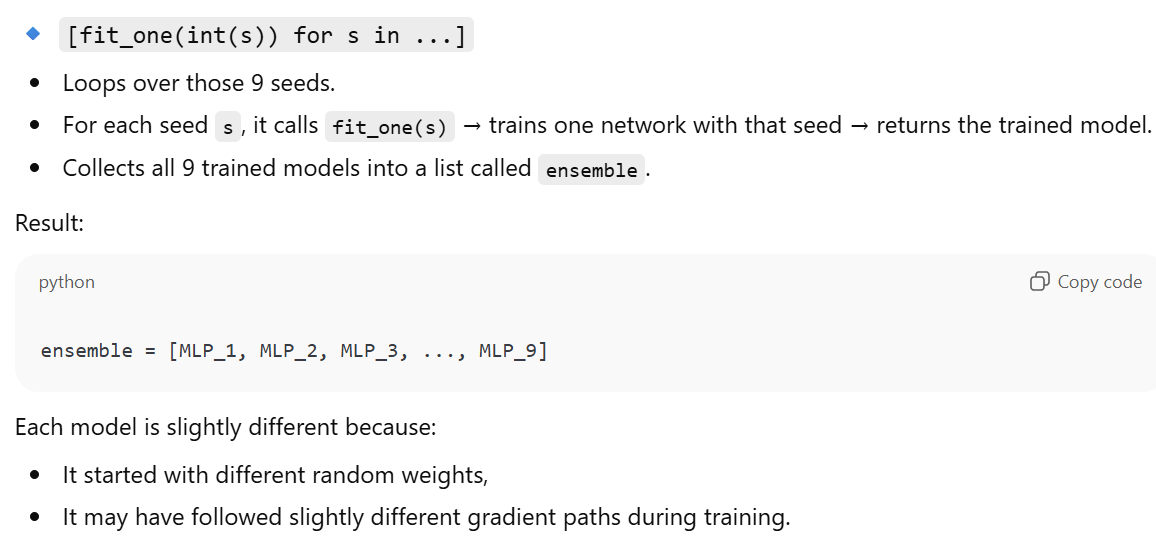
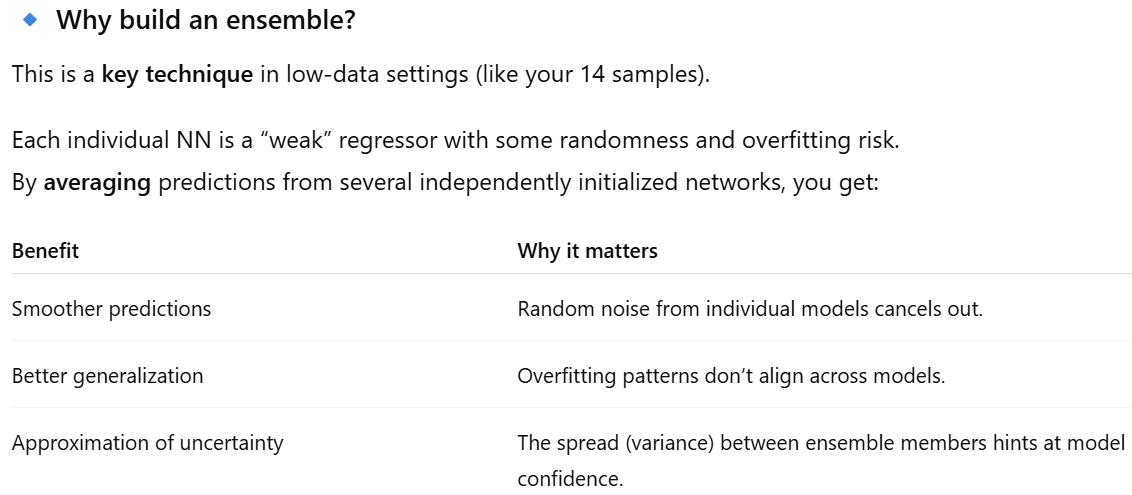
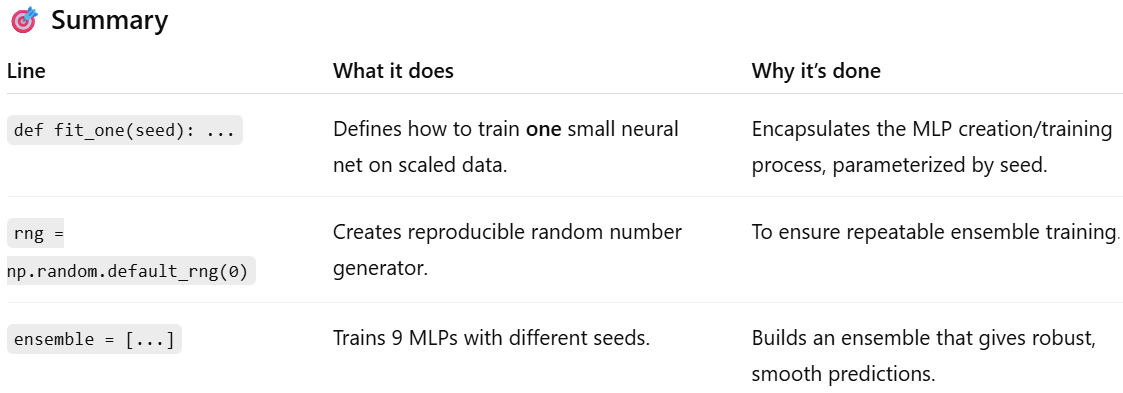

You have a trained NN ensemble that predicts the objective 
𝑦
(
𝑥
)
y(x) at any point 
𝑥
x in 
[
0
,
1
]
2
[0,1]
2
.

You now want to choose the next input x_next to evaluate the true black-box function.
Because evaluations are expensive, you want this choice to be:

exploitive → go where predicted y is high (maximize y),

explorative → focus near promising regions (trust region),

safe → avoid edges or corners (edge penalty).

So you combine these into a single score that ranks every candidate point.
The next query is simply the point with the highest score.

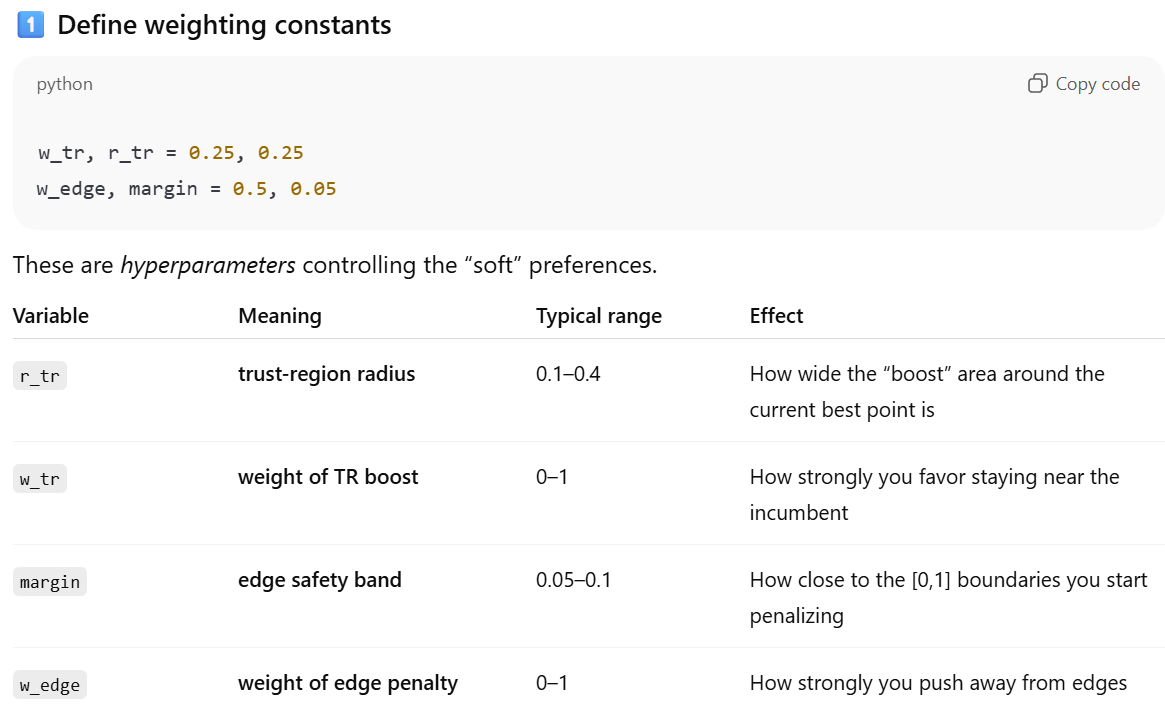

score = mu + w_tr*trust_region_bias(Xcand, x_best, r_tr=r_tr) - w_edge*soft_edge_penalty(Xcand, margin=margin)

▪ mu

The NN ensemble’s predicted mean output at each candidate x.

This is your exploitation term: points with higher predicted y are favored.

Intuition: “Go where I think the function is high.”
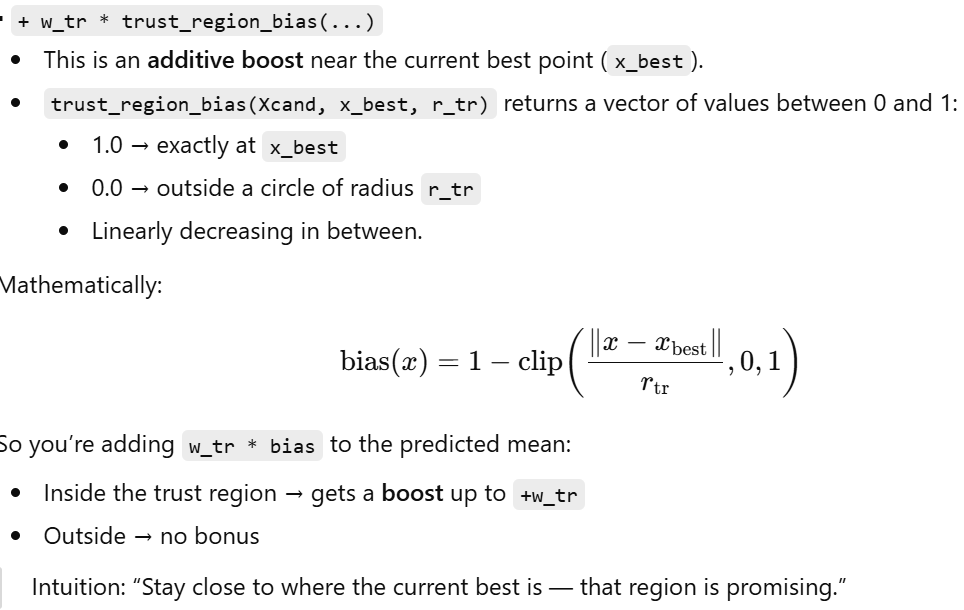
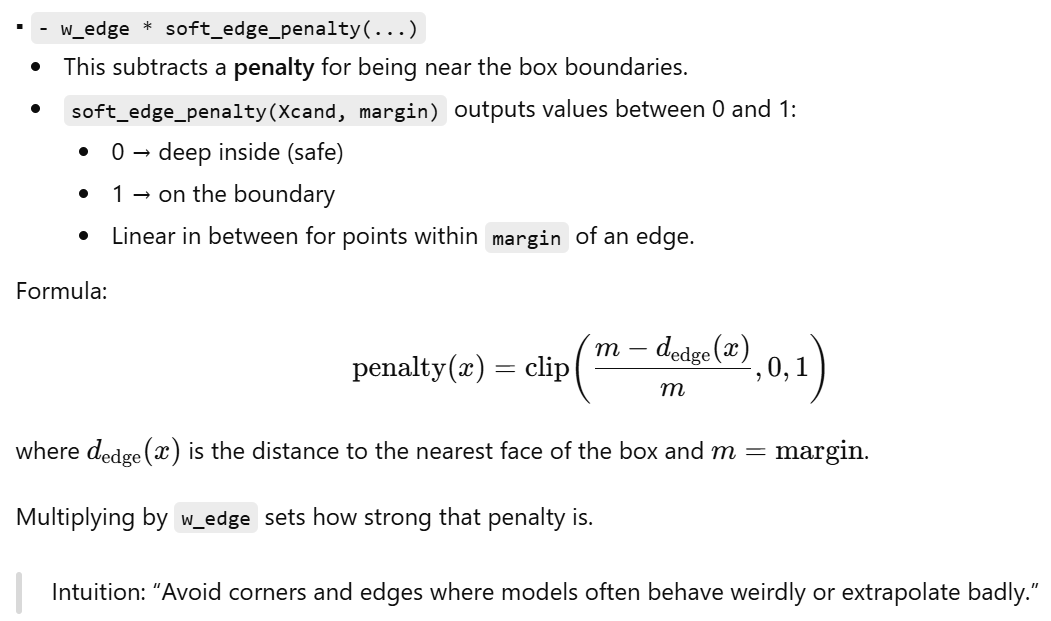
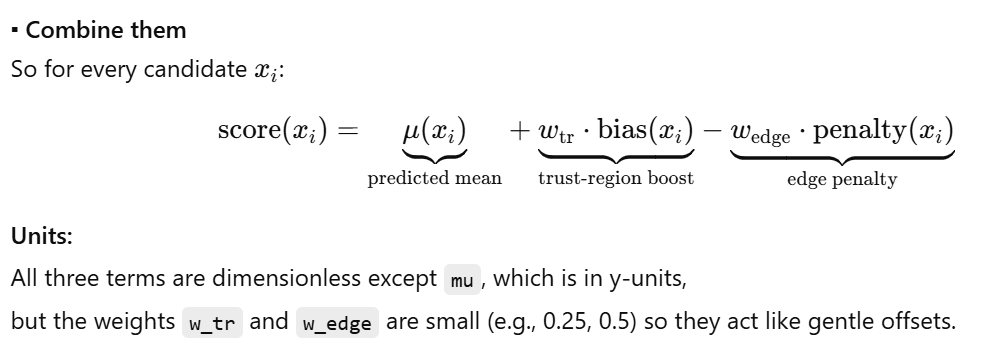
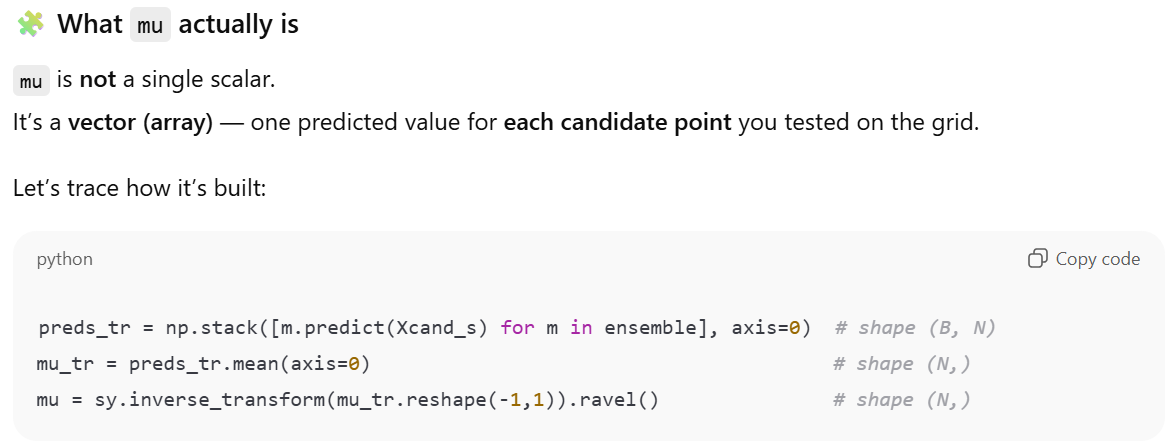
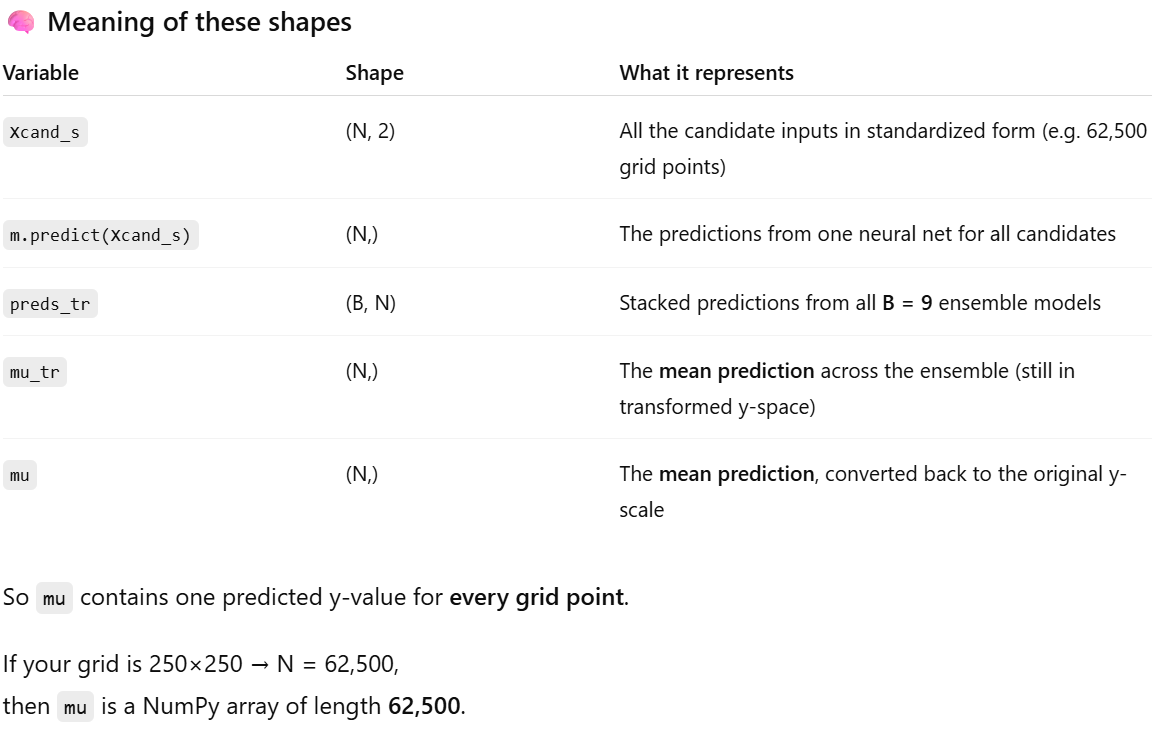
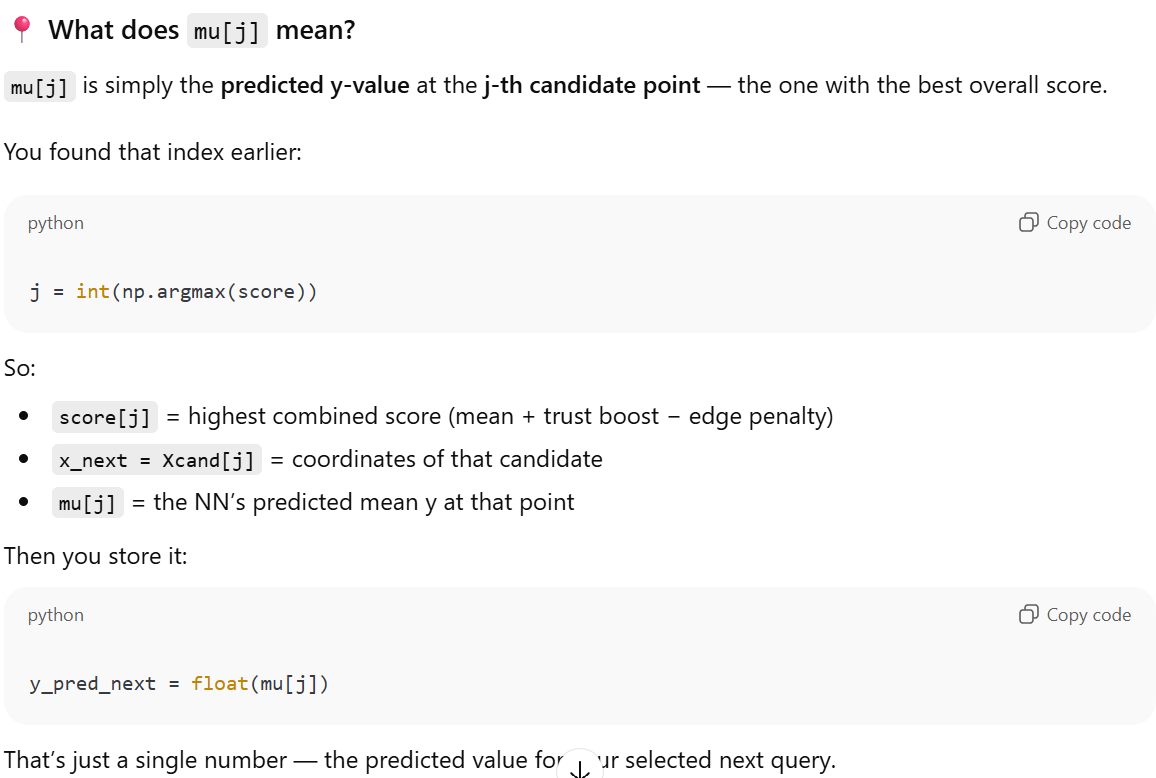
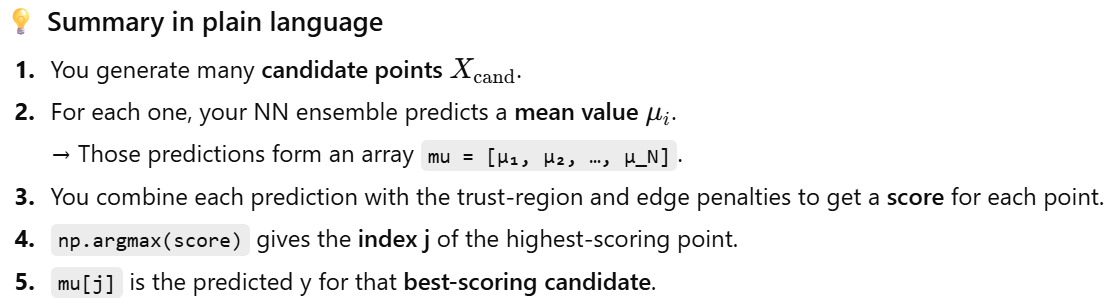